In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import healpy as hp
import fitsio as ft
import numpy as np

import matplotlib.backends.backend_pdf

import sys
sys.path.append('/home/mehdi/github/LSSutils')
import LSSutils.dataviz as dv

from LSSutils.io import readnbodykit
from LSSutils.utils import (hpixsum, shiftra, 
                            steradian2sqdeg, hpix2radec, overdensity)

# N(z)

In [2]:
!head -n 3 /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_*GC_v7_2.dat

==> /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_NGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 2860.4406814189183 99740127.64438488
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00013462213635665303 0.5976890894834057 7771.038808820277 1.046153846153846

==> /B/Shared/mehdi/eboss/data/v7_2/nbar_eBOSS_QSO_SGC_v7_2.dat <==
# effective area (deg^2), effective volume (Mpc/h)^3: 1838.8730140161808 53674436.18509478
# zcen,zlow,zhigh,nbar,wfkp,shell_vol,total weighted gals
0.005 0.0 0.01 0.00020558148614182404 0.4931191556659562 4995.717495292908 1.027027027027027


In [3]:
2860.4406814189183 + 1838.8730140161808

4699.313695435099

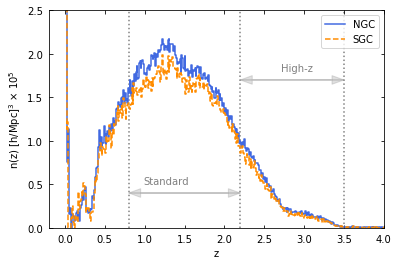

In [7]:
#plt.rc('font', family='serif', size=15)

path_nbar = '/B/Shared/mehdi/eboss/data/v7_2/'
nbar_ngc = np.loadtxt(f'{path_nbar}nbar_eBOSS_QSO_NGC_v7_2.dat')
nbar_sgc = np.loadtxt(f'{path_nbar}nbar_eBOSS_QSO_SGC_v7_2.dat')


fig, ax = plt.subplots(figsize=(6, 4))

kw = dict(where='mid')
ax.step(nbar_ngc[:,0], nbar_ngc[:, 3]/1.0e-5, label='NGC', ls='-', color='royalblue', **kw)
ax.step(nbar_sgc[:,0], nbar_sgc[:, 3]/1.0e-5, label='SGC', ls='--', color='darkorange', **kw)

samples = ['Standard', 'High-z']
lines  = [0.8, 2.2, 3.5]
for i, line in enumerate(lines):
    ax.axvline(line, zorder=0, ls=':', color='grey')
    
    if i<2:
        #-- annotation
        if i==0:
            ypos = 0.5
        else:
            ypos = 1.8
            
        ax.text(1.23*line, ypos, samples[i], color='grey')
        
        hwidth=0.1
        width=0.001
        kw = dict(shape='full', width=width, 
                  head_width=hwidth, color='grey', alpha=0.25)  
        
        # left to right
        ax.arrow(lines[i], ypos-0.1, lines[i+1]-lines[i]-1.5*hwidth, 0.0, **kw)        
        # right to left
        ax.arrow(lines[i+1], ypos-0.1, -lines[i+1]+lines[i]+1.5*hwidth, 0.0, **kw) 

ax.tick_params(direction='in', which='both', axis='both', pad=6, right=True, top=True)
ax.set(xlabel='z', ylabel=r'n(z) [h/Mpc]$^{3}$ $\times$ 10$^{5}$', 
       ylim=(0, 2.5), xlim=(-0.2, 4))
ax.legend()
fig.savefig('figs/fig1-nz.pdf', bbox_inches='tight')

# Mollweide

In [10]:
path_cats = '/B/Shared/mehdi/eboss/data/v7_2/0.3/'
dNGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
rNGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_NGC_v7_2_0.3.ran.fits')

dSGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_SGC_v7_2_0.3.dat.fits')
rSGC = ft.read(f'{path_cats}eBOSS_QSO_clustering_SGC_v7_2_0.3.ran.fits')

data = np.concatenate([dNGC, dSGC])
random = np.concatenate([rNGC, rSGC])

nside  = 512
hpmap0  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ'])
hpmap1  = hpixsum(nside,  data['RA'], data['DEC'],
                 value=data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']*data['WEIGHT_SYSTOT'])
hpmapr = hpixsum(nside, random['RA'], random['DEC'], 
                 value=random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT'])

mask = hpmapr != 0
meanran = np.mean(hpmapr[mask])
frac = hpmapr / meanran


hpmap0[~mask] = np.nan
hpmap1[~mask] = np.nan
density1 = hpmap1/(frac*hp.nside2pixarea(nside, degrees=True))
density0 = hpmap0/(frac*hp.nside2pixarea(nside, degrees=True))



fsky = np.mean(frac)
print(f'total area {steradian2sqdeg(fsky*4*np.pi)}, fsky : {fsky}')

total area 5164.370508432405, fsky : 0.125187873840332


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in true_divide


In [11]:
hp.nside2resol(512, arcmin=True)

6.870972823634812

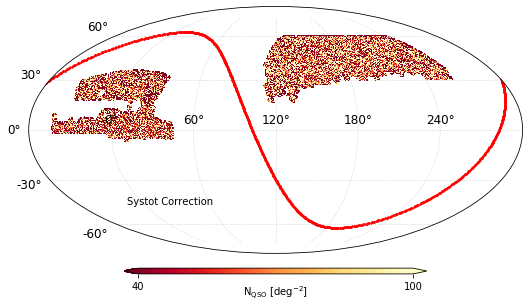

In [13]:

#--- uncomment to add EBV
# import pandas as pd
# df = pd.read_hdf('/home/mehdi/data/templates/SDSS_WISE_HI_imageprop_nside512.h5', 'templates')
# ebv = hp.ud_grade(df.ebv, nside_out=64)
# ebv[~mask]= np.nan

fig = plt.figure(figsize=(7, 4)) # matplotlib is doing the mollveide projection
#ax  = fig.add_subplot(211, projection='mollweide')
#ax1 = fig.add_subplot(312, projection='mollweide')
ax2 = fig.add_subplot(111, projection='mollweide')


spacing = 0.01
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0)


kw = dict(unit=r'N$_{{\rm QSO}}$ [deg$^{-2}$]', cmap=plt.cm.YlOrRd_r, 
         vmin=40, vmax=100, #width=6, 
         extend='both', galaxy=True)

#dv.mollview(density0, figax=[fig, ax], **kw)
# dv.mollview(ebv, figax=[fig, ax1], galaxy=True, vmin=0, 
#             vmax=0.1, cmap=plt.cm.Reds, unit='')
dv.mollview(density1, figax=[fig, ax2], colorbar=True, **kw)

#ax.text(0.2, 0.2, 'No Correction', transform=ax.transAxes)
#ax1.text(0.2, 0.2, 'E(B-V)', transform=ax1.transAxes)
ax2.text(0.2, 0.2, 'Systot Correction', transform=ax2.transAxes)
ax2.grid(True, ls=':', color='grey', alpha=0.4)
plt.savefig('./figs/fig2-mollweide.pdf', 
            bbox_inches='tight', dpi=300, rasterized=True)

In [2]:
from LSSutils.lab import EbossCatalog

In [3]:
dngc = EbossCatalog('/B/Shared/mehdi/eboss/data/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
rngc = EbossCatalog('/B/Shared/mehdi/eboss/data/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits', kind='random')

In [4]:
dngc.tohp(32, raw=False)
rngc.tohp(32, raw=False)

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:481: RuntimeWarning: invalid value encountered in _ang2pix_ring
  return pixlib._ang2pix_ring(nside, theta, phi)


/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 42.,  44.,  33.,  27.,  34.,  66., 151., 447., 198.,  15.]),
 array([  2.91128187,  32.67202491,  62.43276795,  92.19351098,
        121.95425402, 151.71499705, 181.47574009, 211.23648312,
        240.99722616, 270.7579692 , 300.51871223]),
 <a list of 10 Patch objects>)

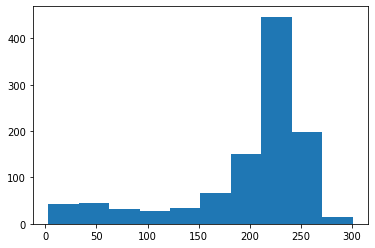

In [14]:
plt.hist(dngc.hpmap)

In [11]:
dngc.hpmap[rngc.hpmap < 1] = np.nan

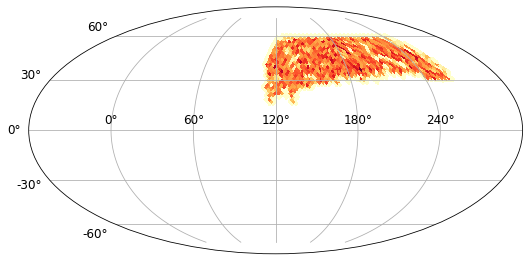

In [15]:
dv.mollview(dngc.hpmap, 150, 300, 'QSO', cmap=plt.cm.YlOrRd)

# predicted number density

/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/healpy/pixelfunc.py:345: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/home/mehdi/miniconda3/envs/py3p6/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater


........

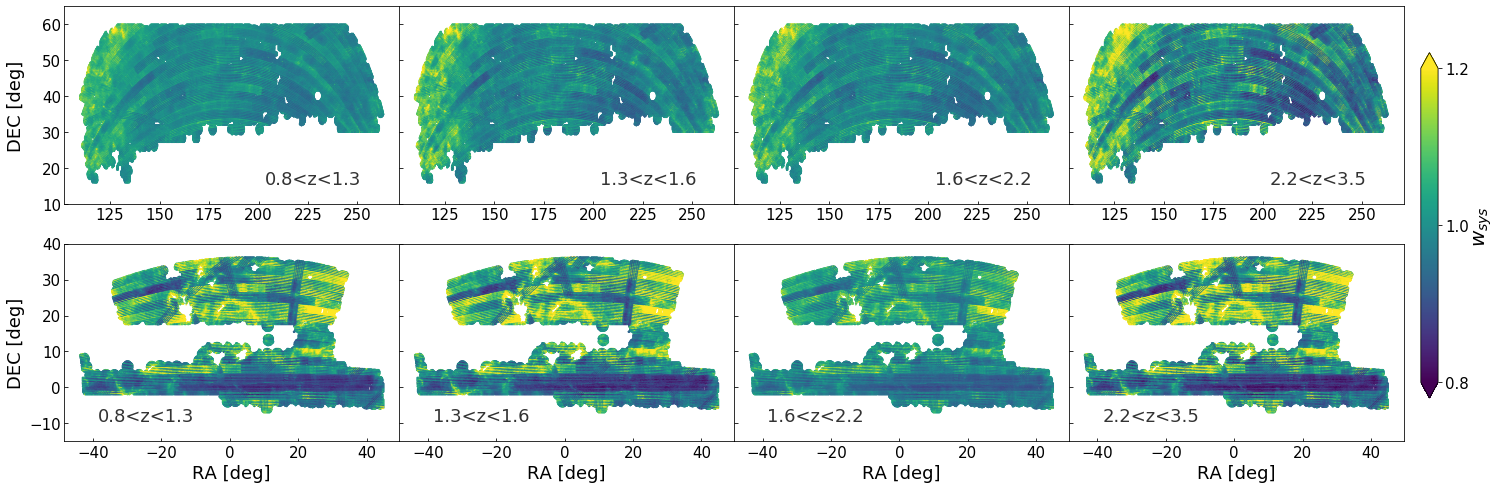

In [2]:
#pdf = matplotlib.backends.backend_pdf.PdfPages('figs/wsys_nn_known_p2_v7_2.pdf')
ncols = 4
fig, ax = plt.subplots(ncols=ncols, nrows=2, figsize=(6*ncols, 8), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
fig.align_labels()
ax= ax.flatten()

for j,cap in enumerate(['NGC', 'SGC']):
    
    path1 = '/home/mehdi/data/eboss/v7_2/0.3/results/'
    path2 = 'regression/nn_known/nn-weights.hp512.fits'
    wmaps = [path1 + f'{cap}_{z}_512/' + path2 for z in ['z1', 'z2', 'z3', 'zhigh']]


    # read maps
    dwmaps = []
    for wmap in wmaps:
        dwmaps.append(hp.read_map(wmap, verbose=False))


    zlims = [[0.8, 1.3], [1.3, 1.6], [1.6, 2.2], [2.2, 3.5]]



    kw = dict(vmax=1.2, vmin=0.8, cmap=plt.cm.viridis, marker='.', rasterized=True)

    for i,dwmap in enumerate(dwmaps):
        print('.', end='')

        ix = j*4+i
        
        hpix = np.argwhere(dwmap > 0).flatten()
        ra, dec = hpix2radec(512, hpix)

        mapi = ax[ix].scatter(shiftra(ra), dec, 1,
                    c=1/dwmap[hpix], **kw)

        if ix <4:
            ax[ix].set_ylim(10, 65)
            xtext = 0.6
        else:
            xtext = 0.1
            ax[ix].set_ylim(-15, 40)

        ax[ix].text(xtext, 0.1, '{}<z<{}'.format(*zlims[i]), 
                    color='k', transform=ax[ix].transAxes, fontsize=18, alpha=0.8)            
        
        ax[ix].tick_params(direction='in', axis='both', which='both', labelsize=15)
        
        if j==1:
            ax[ix].set_xlabel('RA [deg]', fontsize=18) # title='{0}<z<{1}'.format(*zlim)

        if i==0:ax[ix].set_ylabel('DEC [deg]', fontsize=18)

cax = plt.axes([0.91, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.8, 1.0, 1.2], extend='both')
cbar.set_label(label=r'$w_{sys}$', size=20)
cbar.ax.tick_params(labelsize=15)
fig.savefig('figs/fig3-wsys.pdf', bbox_inches='tight')
#pdf.savefig(1, bbox_inches='tight')    
#pdf.close()

# Clustering

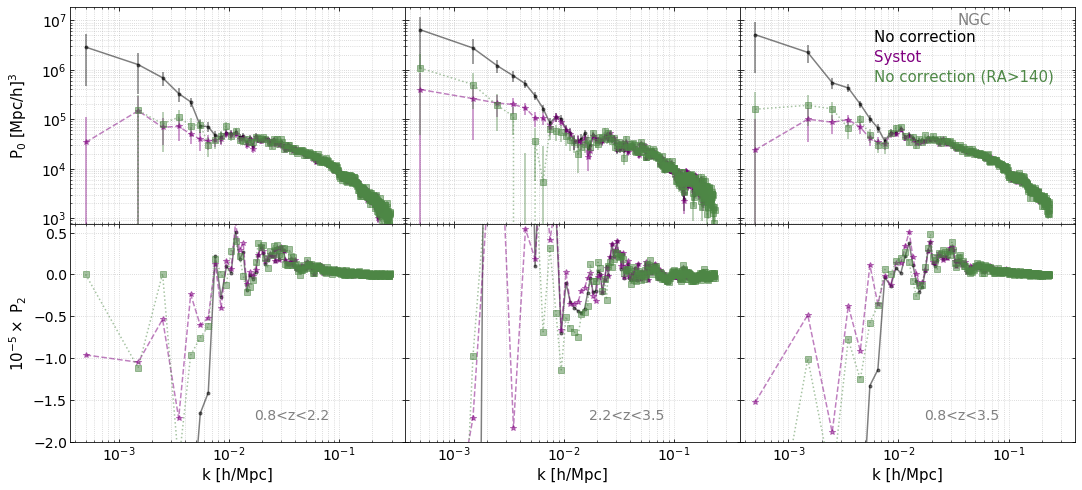

In [16]:
pdfname = 'figs/fig4-pkradec.pdf'

caps = ['NGC'] # only NGC makes sense
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot', 'No correction (RA>140)']
models  = ['wosystot', 'wsystot', 'wosystot_racut']
#treatments = ['No correction (RA cut)', 'Systot (RA cut)']
#models  = ['wosystot_racut', 'wsystot_racut']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', '#4d8745', 'purple']

ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 
pdf_i = 0

for cap in caps:    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                           sharey='row', sharex=True)
    ax = ax.flatten()
    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5
            
            # monopole
            ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise,
                           yerr=err,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)
            
            # quadrupole
            ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5,
                           label=treatments[i], ls=ls[i], c=c[i], marker=mk[i], alpha=0.5)

    ##-- cosmetics
    # redshifts
    for i, sample in enumerate(samples):
        ax[i+3].text(0.55, 0.1, 
                   labels[sample], 
                   color='grey',
                   transform=ax[i+3].transAxes,
                    fontsize=14)




    # labels
    ax[2].text(0.65, 0.92, cap.upper(), color='grey', 
               transform=ax[2].transAxes, fontsize=15)
    for i in range(len(models)):
        j == 2 # top right
        ax[j].text(0.4, 0.84-i*0.09, 
                   treatments[i], 
                   color=c[i], 
                   transform=ax[j].transAxes,
                   fontsize=15)

    # x-y axes labels
    for i, axi in enumerate(ax):
        axi.tick_params(direction='in', axis='both', which='both',
                       right=True, top=True, labelsize=14)
        axi.set(xscale='log')#, yscale='log')
        axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
        if i<3:
            axi.set_yscale('log')
            if i==0:
                axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$', fontsize=15)
        else:
            axi.set_xlabel('k [h/Mpc]', fontsize=15)
            if i==3:
                axi.set_ylim(-2, 0.6)
                axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$', fontsize=15)
    fig.align_labels()
    pdf.savefig((pdf_i+1), bbox_inches='tight')
pdf.close()

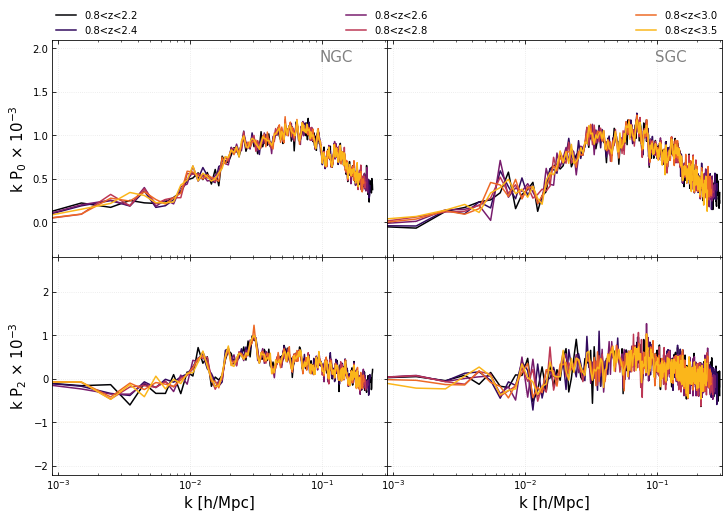

In [40]:
caps = ['NGC', 'SGC']
samples = ['standard', 'zextend2.4', 'zextend2.6', 'zextend2.8',  'zextend3.0', 'combined']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, 
                       figsize=(6*ncols, 8), 
                       sharey='row', sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set_ylim(-0.4, 2.1)
    ax[k+2].set_ylim(-2.2, 2.8)
    ax[k].set(xlim=(0.0009, 0.31))
    ax[k+2].set(xlim=(0.0009, 0.31))#xscale='log')
    ax[k+2].set_xlabel('k [h/Mpc]', fontsize=15)

    ax[k].grid(True, ls=':',   color='grey', which='major', alpha=0.2)
    ax[k+2].grid(True, ls=':', color='grey', which='major', alpha=0.2)
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$', fontsize=15)
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$', fontsize=15)
        
    ax[k].text(0.8, 0.9, cap.upper(), color='grey',
               transform=ax[k].transAxes, fontsize=15)

for axi in ax:
    axi.set_xscale('log')
    axi.tick_params(direction='in', axis='both', 
                    which='both', right=True, top=True)
fig.align_labels()
fig.savefig('figs/fig5-pk_standardzmax.pdf', bbox_inches='tight')

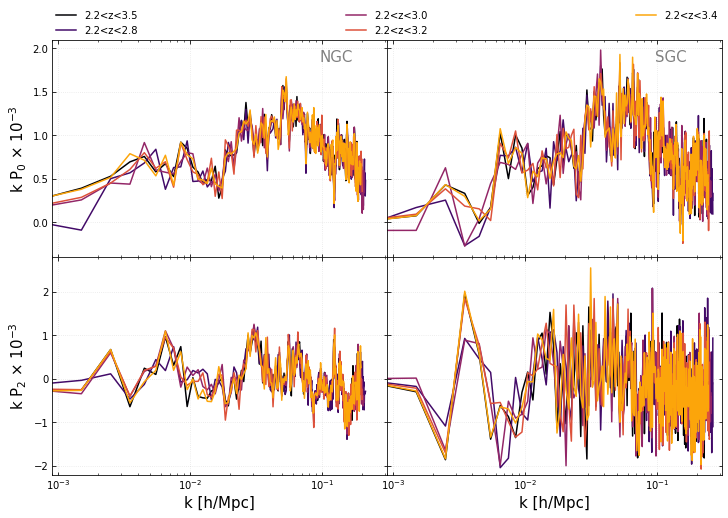

In [39]:
caps = ['NGC', 'SGC']
samples = ['zhigh', 'hizextend2.8', 'hizextend3.0', 'hizextend3.2', 'hizextend3.4']
treatments = ['systot']
models  = ['wsystot']

mk = ['.', '*', 's', '^', '>', 'o']
c = [plt.cm.inferno(i/len(samples)) for i in range(len(samples))]
ls = 2*['-', '--', ':', '-.']
path = '/home/mehdi/data/eboss/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'

labels = {'zhigh':'2.2<z<3.5',
          'standard':'0.8<z<2.2',
          'zextend2.4':'0.8<z<2.4',
          'zextend2.6':'0.8<z<2.6',
          'zextend2.8':'0.8<z<2.8',
          'zextend3.0':'0.8<z<3.0',
          'combined':'0.8<z<3.5',
          'hizextend2.8':'2.2<z<2.8',
          'hizextend3.0':'2.2<z<3.0',          
          'hizextend3.2':'2.2<z<3.2',
          'hizextend3.4':'2.2<z<3.4'} 

legendkw = dict(ncol=3, frameon=False,
                 bbox_to_anchor=(0.0, 1.0, 2., 0.4), loc="lower left",
                 mode="expand", borderaxespad=0)

ncols=2
fig, ax = plt.subplots(ncols=ncols, nrows=2, 
                       figsize=(6*ncols, 8), 
                       sharey='row', sharex=True)
ax = ax.flatten()
fig.subplots_adjust(wspace=0.0, hspace=0.0)

for k,cap in enumerate(caps):    

    for j, sample in enumerate(samples):

        for i,model in enumerate(models):

            pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))
            
            # quadrupole
            #positive = pk_i[:,3]>0
            ax[k].plot(pk_i[:,0], pk_i[:,0]*(pk_i[:,2]-shotnoise)/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            ax[k+2].plot(pk_i[:,0], pk_i[:,0]*pk_i[:,3]/1.0e3,
                           label=labels[sample], c=c[j], ls='-')

            
    
    ax[k].set_ylim(-0.4, 2.1)
    ax[k+2].set_ylim(-2.2, 2.8)
    ax[k].set(xlim=(0.0009, 0.31))
    ax[k+2].set(xlim=(0.0009, 0.31))#xscale='log')
    ax[k+2].set_xlabel('k [h/Mpc]', fontsize=15)

    ax[k].grid(True, ls=':',   color='grey', which='major', alpha=0.2)
    ax[k+2].grid(True, ls=':', color='grey', which='major', alpha=0.2)
    
    if k==0:
        ax[k].legend(**legendkw)
    if k%2 == 0:
        ax[k].set_ylabel(r'k P$_{0}$ $\times$ 10$^{-3}$', fontsize=15)
        ax[k+2].set_ylabel(r'k P$_{2}$ $\times$ 10$^{-3}$', fontsize=15)
        
    ax[k].text(0.8, 0.9, cap.upper(), color='grey',
               transform=ax[k].transAxes, fontsize=15)

for axi in ax:
    axi.set_xscale('log')
    axi.tick_params(direction='in', axis='both', 
                    which='both', right=True, top=True)
fig.align_labels()
fig.savefig('figs/fig6-pk_highzmax.pdf', bbox_inches='tight')

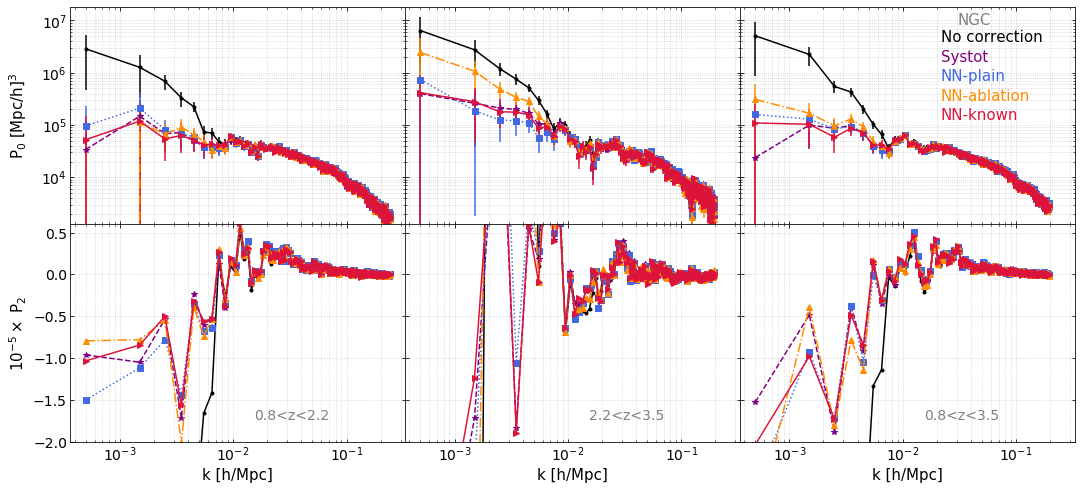

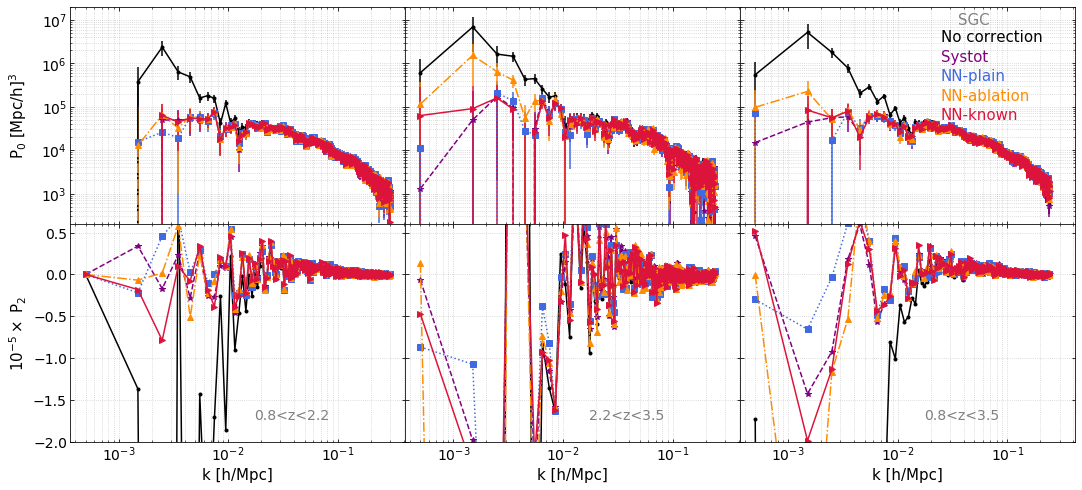

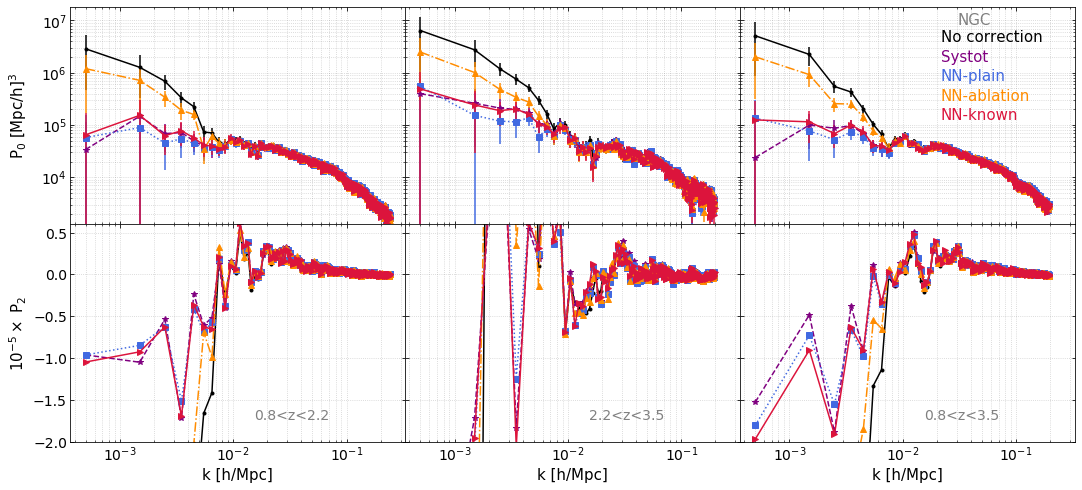

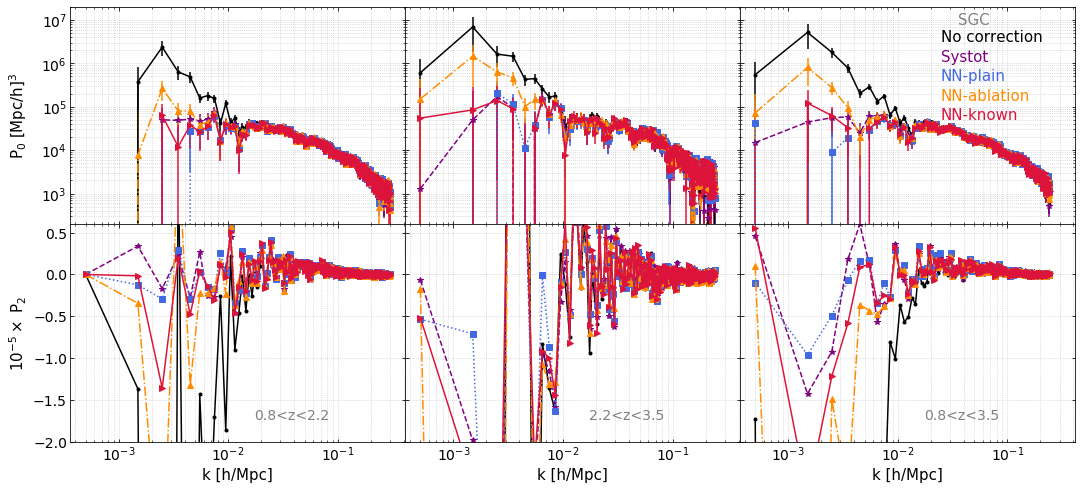

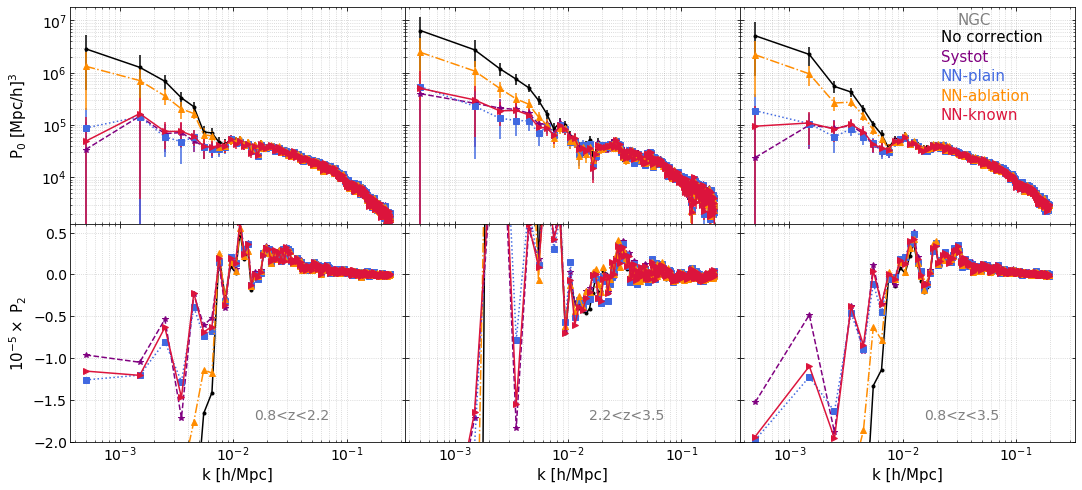

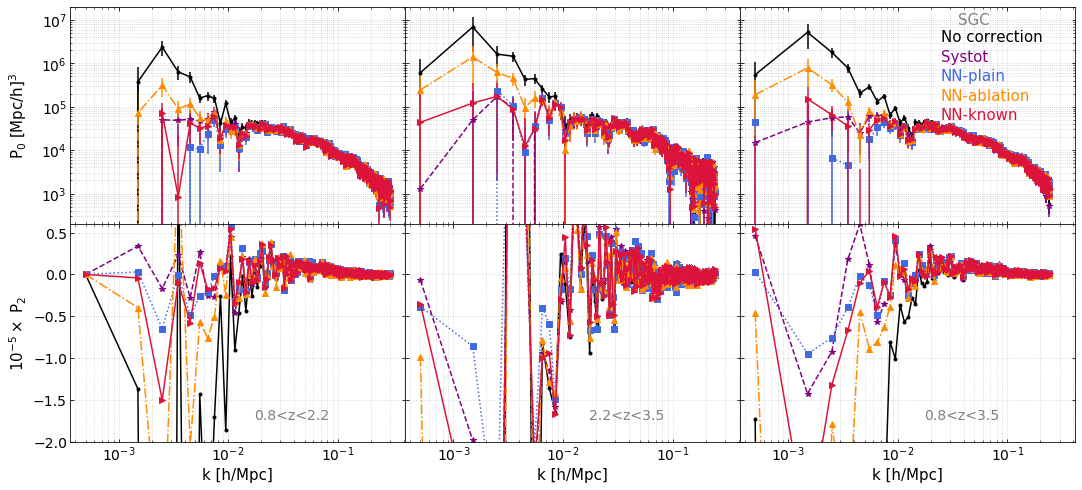

In [2]:
pdfname = 'figs/eboss_qso_v7_2_p3.pdf'

caps = ['NGC', 'SGC']
samples = ['standard', 'zhigh', 'combined']
treatments = ['No correction', 'Systot',   'NN-plain', 'NN-ablation', 'NN-known']

models2z  = ['wosystot', 'wsystot',  'plain_allhigh', 'ablation_allhigh', 'known_allhigh']
models3z  = ['wosystot', 'wsystot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']
models4z  = ['wosystot', 'wsystot',  'plain_z3high', 'ablation_z3high', 'known_z3high']

mk = ['.', '*', 's', '^', '>', 'o']
c = ['k', 'purple', 'royalblue', 'darkorange', 'crimson']
#c = [plt.cm.gnuplot(i/len(models)) for i in range(len(models))]

ls = 2*['-', '--', ':', '-.']
path = '/B/Shared/mehdi/eboss/data/v7_2/0.3/'
pkout = lambda cap, model, sample : f'pk_{cap}_v7_2_0.3_{model}_512_{sample}.txt'
labels = {'standard':'0.8<z<2.2',
           'zhigh':'2.2<z<3.5',
          'combined':'0.8<z<3.5'} 



pdf = matplotlib.backends.backend_pdf.PdfPages(pdfname) 

pdf_i = 0
for k, models in enumerate([models2z, models3z, models4z]):
    
    for cap in caps:    
        fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(18, 8), 
                               sharey='row', sharex=True)
        ax = ax.flatten()
        fig.subplots_adjust(wspace=0.0, hspace=0.0)

        for j, sample in enumerate(samples):

            for i,model in enumerate(models):
                
                kwargs = dict(label=treatments[i], ls=ls[i], c=c[i], marker=mk[i])
                
                pk_i, shotnoise = readnbodykit(path + pkout(cap, model, sample))

                err = pk_i[:,2]/(0.5*pk_i[:,5])**0.5

                # monopole
                ax[j].errorbar(pk_i[:,0], pk_i[:,2]-shotnoise, yerr=err, **kwargs)

                # quadrupole
                #if (model=='wosystot') | ('ablation' in model):
                #    continue
                ax[j+3].errorbar(pk_i[:,0], pk_i[:,3]/1e5, **kwargs)

        ##-- cosmetics
        # redshifts
        for i, sample in enumerate(samples):
            ax[i+3].text(0.55, 0.1, 
                       labels[sample], 
                       color='grey',
                       transform=ax[i+3].transAxes,
                        fontsize=14)




        # labels
        ax[2].text(0.65, 0.92, cap.upper(), color='grey', 
                   transform=ax[2].transAxes, fontsize=15)
        for i in range(len(models)):
            j == 2 # top right
            ax[j].text(0.6, 0.84-i*0.09, 
                       treatments[i], 
                       color=c[i], 
                       transform=ax[j].transAxes,
                       fontsize=15)

        # x-y axes labels
        for i, axi in enumerate(ax):
            axi.tick_params(direction='in', axis='both', which='both',
                           right=True, top=True, labelsize=14)
            axi.set(xscale='log')#, yscale='log')
            axi.grid(True, ls=':', color='grey', which='both', alpha=0.4)
            if i<3:
                axi.set_yscale('log')
                if i==0:
                    axi.set_ylabel(r'P$_{0}$ [Mpc/h]$^{3}$', fontsize=15)
            else:
                axi.set_xlabel('k [h/Mpc]', fontsize=15)
                if i==3:
                    axi.set_ylim(-2, 0.6)
                    axi.set_ylabel(r'10$^{-5} \times$ P$_{2}$', fontsize=15)

        fig.align_labels()
        pdf.savefig((pdf_i+1), bbox_inches='tight')
        pdf_i += 1
pdf.close()  

## correlation function

In [3]:
import nbodykit.lab as nb
from nbodykit.cosmology import CorrelationFunction
from nbodykit.cosmology import Planck15

In [4]:
Plin = nb.cosmology.LinearPower(Planck15, 2.85, transfer='CLASS')
Xilin = CorrelationFunction(Plin)

In [5]:
xi_systot = nb.SurveyData2PCF.load('/B/Shared/mehdi/eboss/data/v7_2/0.3/xi_NGC_v7_2_0.3_wsystot_512_zhigh.json')

In [10]:
xi_systot.corr['corr'].shape

(21, 120)

In [14]:
xi_systot.corr['r']

array([[  6.26099949,   5.77688213,   7.70497442, ...,   6.63404583,
          6.4583946 ,   6.40174771],
       [ 15.69596181,  15.86297637,  17.79104275, ...,  14.75436097,
         15.73361559,  15.1421023 ],
       [ 25.46381823,  24.95053706,  26.30515267, ...,  24.74204192,
         25.87553001,  25.44489591],
       ...,
       [185.12112687, 185.07242105, 185.12096914, ..., 185.04544234,
        185.04087695, 185.12293416],
       [195.00955142, 195.12929529, 194.98613297, ..., 195.06487631,
        195.06702886, 194.95431344],
       [205.06297581, 205.05223021, 205.05811315, ..., 205.08138849,
        205.13549661, 204.93369255]])

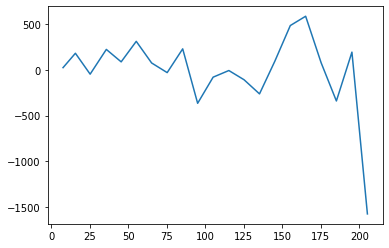

In [30]:
_=plt.plot(xi_systot.corr['r'][:, 50], xi_systot.corr['r'][:, 0]**2*xi_systot.corr['corr'][:, 50])

In [31]:
xi_poles = xi_systot.corr.to_poles([0, 2, 4])

In [43]:
xi_systot.corr

<WedgeBinnedStatistic: dims: (r: 21, mu: 120), variables: ('corr', 'r')>

In [48]:
xi_poles_mid = xi_systot.corr.sel(mu=slice(0.33, 0.66), method='nearest').to_poles([0, 2, 4])

In [60]:
xi_poles['r']

array([  7.07784714,  15.84015522,  25.53125851,  35.46186481,
        45.32905694,  55.27543545,  65.2423824 ,  75.20121617,
        85.16936034,  95.13847092, 105.13538016, 115.12736121,
       125.11604618, 135.10147266, 145.10130344, 155.08816127,
       165.08965169, 175.08613247, 185.07464867, 195.06771026,
       205.07174763])

Text(0, 0.5, 'r$^{2} \\xi_{0}$(r)')

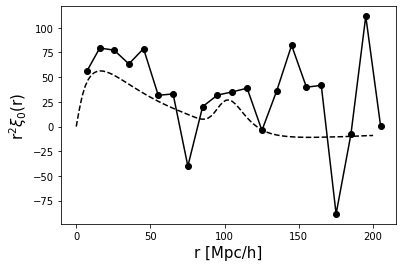

In [75]:
ls = ['-', '--']
c = ['k', 'orange', 'green']

rt = np.linspace(0, 200, 100)

for i, xi_i in enumerate([xi_poles]):#, xi_poles_mid]):
    
    for j, ell in enumerate([0]):
        plt.plot(xi_i['r'], xi_i['r']**2*xi_i['corr_%d'%ell],
                c=c[j], ls=ls[i], marker='o')
    
    plt.plot(rt, 13.5*rt**2*Xilin(rt), ls='--', color='k')
    
plt.xlabel('r [Mpc/h]', fontsize=15)
plt.ylabel(r'r$^{2} \xi_{0}$(r)', fontsize=15)

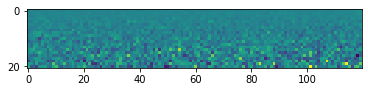

In [25]:
plt.imshow(xi_systot.corr['r']**2*xi_systot.corr['corr'][:, :])

In [6]:
pk_high_b = nb.ConvolvedFFTPower.load('/B/Shared/mehdi/eboss/data/v7_2/0.3/pk_NGC_v7_2_0.3_wosystot_512_zhigh.json')
pk_high_a = nb.ConvolvedFFTPower.load('/B/Shared/mehdi/eboss/data/v7_2/0.3/pk_NGC_v7_2_0.3_plain_w1depthg_lowmidhigh_512_zhigh.json')
pk_high_s = nb.ConvolvedFFTPower.load('/B/Shared/mehdi/eboss/data/v7_2/0.3/pk_NGC_v7_2_0.3_wsystot_512_zhigh.json')

In [34]:
def add_pk(pk_high, ax, legend=False, **kw):    
    
    mu_edges = np.array([0, 0.33, 0.66, 1.0])
    pk_mu = pk_high.to_pkmu(mu_edges, 4)
    ls = ['-', '--', ':']
    for i in range(pk_mu.shape[1]):
        Pk = pk_mu[:,i] # select the ith mu bin
        label = r'$\mu$=%.2f' % (pk_mu.coords['mu'][i])

        k = Pk['k']
        pk = Pk['power'].real - Pk.attrs['shotnoise'] # (Pk['power'].real-Pk.attrs['shotnoise']), 
        if legend:
            ax[i].plot(k, pk, marker='.', ls=ls[i], label=label, **kw)
        else:
            ax[i].plot(k, pk, marker='.', ls=ls[i], **kw)
        
        #ax.set_xscale('log')
        # ax.set_yscale('log')
        if legend:
            ax[i].legend()

In [22]:
Plin

Text(0, 0.5, 'P(k, mu)')

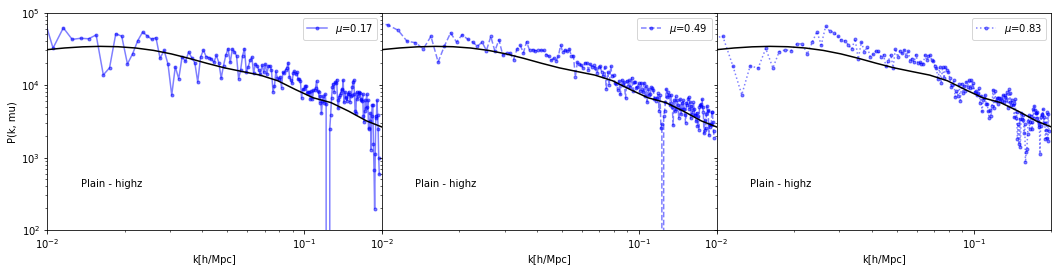

In [47]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fig.subplots_adjust(wspace=0.)

# add_pk(pk_high_b, ax, legend=True)
add_pk(pk_high_a, ax, color='blue', legend=True, alpha=0.5)
# add_pk(pk_high_s, ax, legend=True, color='blue', alpha=0.5)

kt = np.logspace(-2, 0, 30)
for axi in ax:
    axi.plot(kt, 12.5*Plin(kt), 'k-')
    axi.set(xlabel='k[h/Mpc]',
        xlim=(0.01, 0.2), ylim=(1.0e2, 1e5), yscale='log', xscale='log')
    #axi.text(0.1, 0.2, 'Systot - highz', transform=axi.transAxes)
    axi.text(0.1, 0.2, 'Plain - highz', transform=axi.transAxes)
    
ax[0].set_ylabel('P(k, mu)')
# ax.text(0.1, 0.2, 'No treatment - highz', transform=ax.transAxes)

In [48]:
mu_edges = np.array([0, 0.33, 0.66, 1.0])
pkmu_high = pk_high_s.to_pkmu(mu_edges, 4)

(100.0, 100000.0)

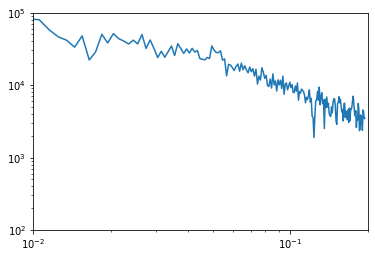

In [68]:
plt.loglog(pkmu_high['k'][:, 1], pkmu_high['power'][:, 1].real - pkmu_high.attrs['shotnoise'])
plt.xlim(0.01, 0.2)
plt.ylim(1.e2, 1.e5)

In [70]:
pkmu_high.attrs['shotnoise']

184495.6722657263

In [69]:
for a,b in zip(pkmu_high['k'][:, 1], pkmu_high['power'][:, 1].real-pkmu_high.attrs['shotnoise']):
    print(a, b)

0.0005083483410999179 661949.6
0.001707805204205215 444741.12
0.002505126962205395 222459.02
0.0034951451579453767 157424.3
0.0044874384524827855 193709.39
0.005488544263103059 131039.734
0.0065543202009783795 156886.86
0.0075155125873148905 64420.266
0.008502009614123463 129523.3
0.009500483243053803 81630.55
0.010560119952756486 79755.516
0.011574898769858441 57463.953
0.012518656224193117 46345.797
0.01350182474427961 41487.5
0.014510701596016348 33319.094
0.015512737169412512 47644.5
0.016537132338358615 22164.578
0.01749880720572225 28607.203
0.018511519554937093 50065.28
0.019503514813574086 38094.562
0.020523607822240525 51196.703
0.02152612908258637 43639.453
0.022516803404428402 40477.812
0.02351273255696472 36841.5
0.02452216463775601 41625.97
0.025501189145132403 36949.703
0.026507953329120836 49791.812
0.02748413009946331 31951.531
0.02851876688965142 41861.594
0.029514888891891654 31839.344
0.03051090215965712 23953.344
0.031498540468904795 29223.266
0.03250234032062015 24

In [14]:
pk_old = readnbodykit('/B/Shared/mehdi/eboss/data/v7_2/0.2/pk_NGC_v7_2_0.2_plain_lowmidhigh_512_standard.txt')
pk_new = readnbodykit('/B/Shared/mehdi/eboss/data/v7_2/0.3/pk_NGC_v7_2_0.3_plain_lowmidhigh_512_standard.txt')

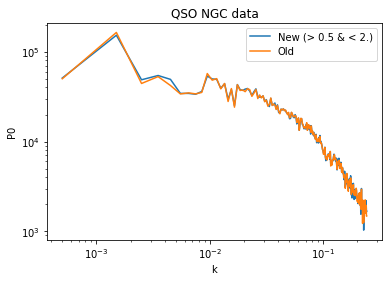

In [18]:
for ni, pki in zip(['New (> 0.5 & < 2.)', 'Old'], [pk_new, pk_old]):
    ki = pki[0][:, 0]
    p0i = pki[0][:, 2] - pki[1]
    plt.loglog(ki, p0i, label=ni)
    
plt.xlabel('k');plt.ylabel('P0');plt.title('QSO NGC data')
plt.legend()

In [2]:
from glob import glob
from LSSutils.lab import datarelease as dl
xlabels = dl.cols_eboss_mocks_qso

In [3]:
def make_chi2_from_nnbar(cap):
    
    pdf = matplotlib.backends.backend_pdf.PdfPages(f'figs/chi2_nbar_{cap}.pdf') 
    nbars = glob(f'/B/Shared/mehdi/eboss/data/v7_2/0.3/clustering/nnbar*{cap}*.npy')


    # --- 
    nnbar = {}
    for nbi in nbars:
        keyi = nbi.split('/')[-1][10:-4]
        nnbar[keyi] = np.load(nbi, allow_pickle=True)



    chi2 = lambda y,ye: (((y-1)*(y-1))/(ye*ye)).mean()
    chi2d = {}

    for k in nnbar.keys():

        chi2l = []
        for nbi in nnbar[k]:
            chi2l.append(chi2(nbi['nnbar'], nbi['nnbar_err']))

        chi2d[k] = chi2l


    pdf_i = 0
    for model in ['plain', 'known', 'ablation']:


        fig, axs = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
        fig.subplots_adjust(wspace=0.02)
        axs = axs.flatten()

        labels = {'low':'0.8<z<1.5',
                 'high':'1.5<z<2.2',
                 'zhigh':'2.2<z<3.5'}

        #model = 'plain'


        for (ax, zr) in zip(axs, ['low', 'high', 'zhigh']):

            ax.bar(np.arange(20)-0.21, chi2d[f'{cap}_systot_{zr}'], width=0.2, label='systot (allhigh)')
            ax.bar(np.arange(20), chi2d[f'{cap}_{model}_allhigh_{zr}'], width=0.2, label='2z (allhigh)')

            if zr != 'zhigh':        
                ax.bar(np.arange(20)+0.21, chi2d[f'{cap}_{model}_lowmidhigh_{zr}'], width=0.2, label='3z (lowmidhigh)')            
                ax.bar(np.arange(20)+0.42, chi2d[f'{cap}_{model}_z3high_{zr}'], width=0.2, label='4z (z3high)')

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            # ax.spines['left'].set_position(('outward', 5))
            # ax.spines['bottom'].set_position(('outward', 5))

            ax.axhline(1, ls=':', color='grey')
            ax.set_xticks(np.arange(20))

            if zr == 'high':
                ax.set_title(model)

            if zr == 'low':
                ax.legend()
                ax.set_ylabel(r'$\chi_{r}^{2}(s)$')

            #ax.set_ylim(0, 20)
            ax.text(0.3, 0.8, labels[zr], transform=ax.transAxes)
            _=ax.set_xticklabels(xlabels, rotation=90)

        #plt.show()
        pdf.savefig((pdf_i+1), bbox_inches='tight')
        pdf_i += 1
    pdf.close()
    del pdf
    print(f'{cap} done')

NGC done


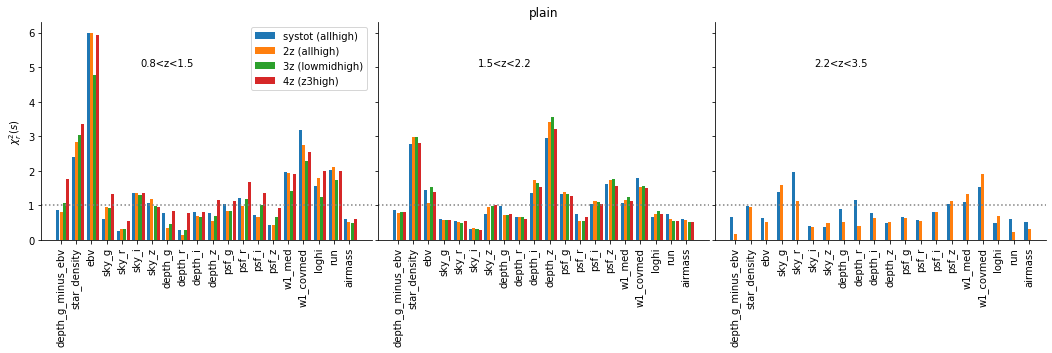

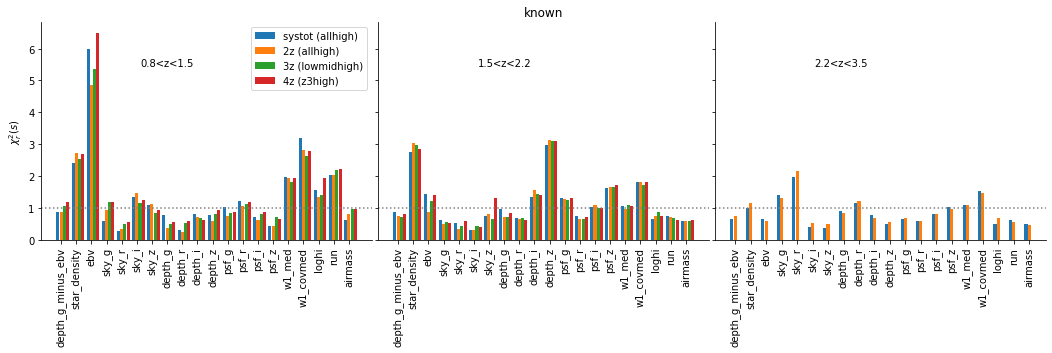

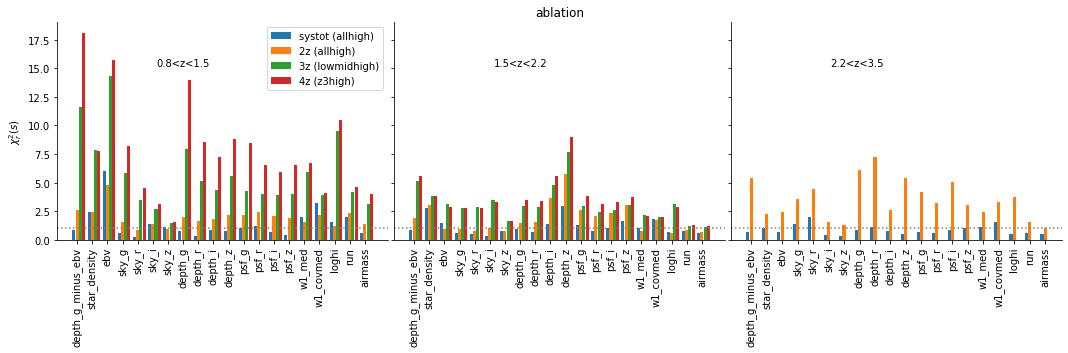

In [5]:
make_chi2_from_nnbar('NGC')

SGC done


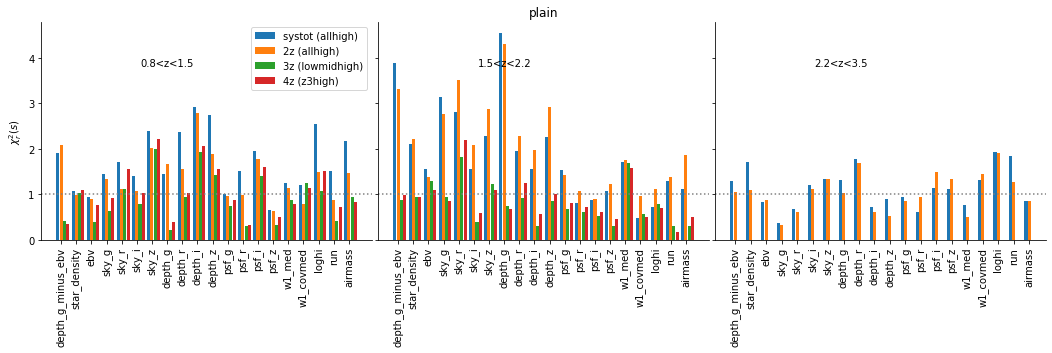

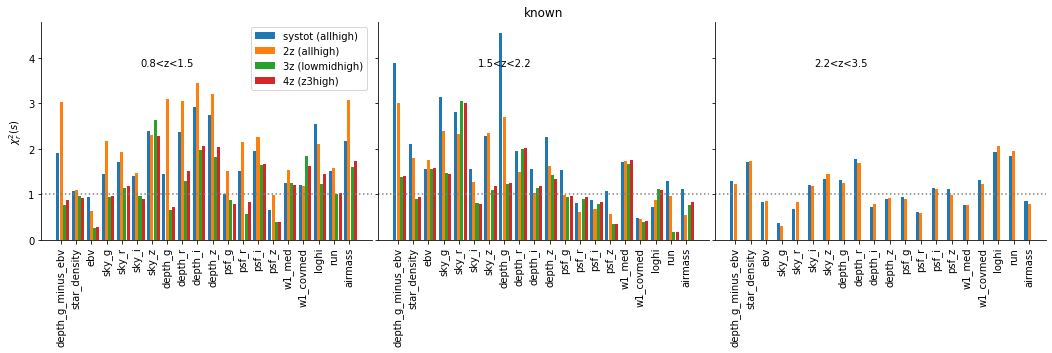

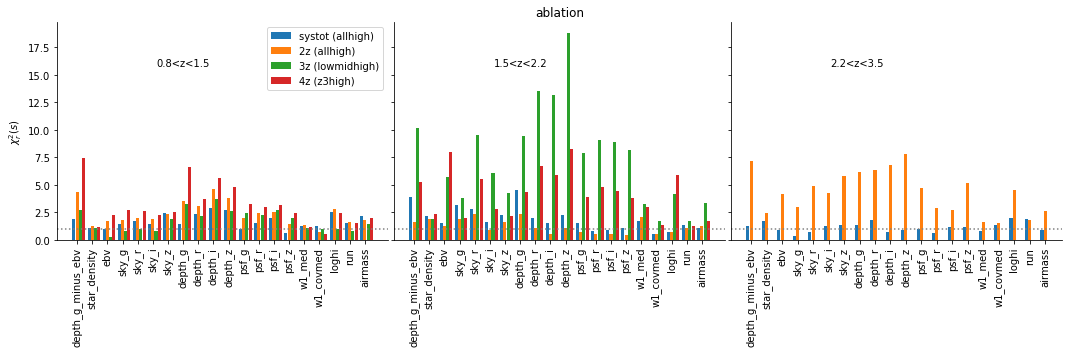

In [6]:
make_chi2_from_nnbar('SGC')

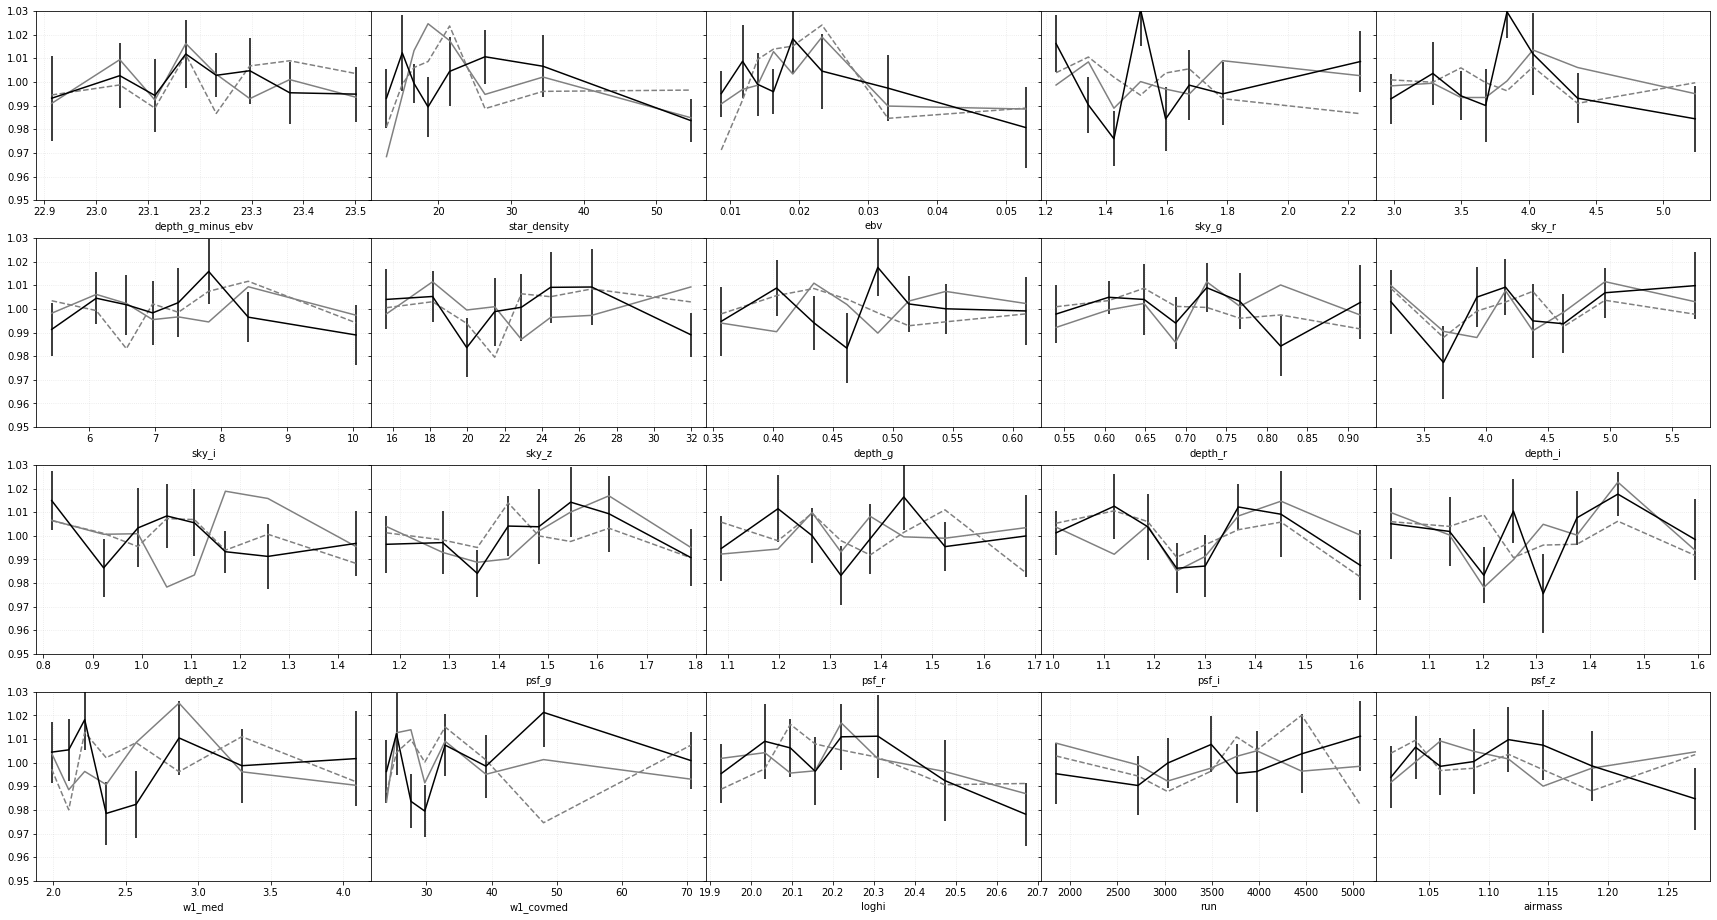

In [35]:
def add_plot(nnbar, ax, error=False, **kw):
    
    for i, nnbar_i in enumerate(nnbar):
        x = nnbar_i['bin_avg']
        y = nnbar_i['nnbar']
        ye = nnbar_i['nnbar_err']

        if error:
            ax[i].errorbar(x, y, ye, **kw)
        else:
            ax[i].plot(x, y, **kw)


fig, ax = plt.subplots(ncols=5, nrows=4, 
                       figsize=(30, 16), sharey=True)
fig.subplots_adjust(wspace=0)
ax = ax.flatten()


cap = 'NGC'
model = 'plain_lowmidhigh' #'systot'
zr = ['low', 'high', 'zhigh']


color = {'low':'grey', 
         'high':'grey',
         'zhigh':'k'}

ls = {'low':'--',
     'high':'-',
     'zhigh':'-'}


for zi in zr:
    
    ki = f'{cap}_{model}_{zi}'
    error = True if zi=='zhigh' else False
    
    add_plot(nnbar[ki], ax, error=error, color=color[zi], ls=ls[zi])


for i, ai in enumerate(ax):
    ai.set_xlabel(xlabels[i])
    ai.grid(True, ls=':', color='grey', alpha=0.2)
    ai.set_ylim(0.95, 1.03)

## Cl

In [2]:
from LSSutils.utils import histogram

In [3]:
cols_eboss_mocks_qso = ['depth_g_minus_ebv', 'star_density', 
                        'ebv',
                        'sky_g', 'sky_r', 'sky_i', 'sky_z',
                        'depth_g','depth_r', 'depth_i', 'depth_z', 
                        'psf_g', 'psf_r', 'psf_i', 'psf_z',
                        'w1_med', 'w1_covmed', 
                        'loghi', 'run', 'airmass']

..

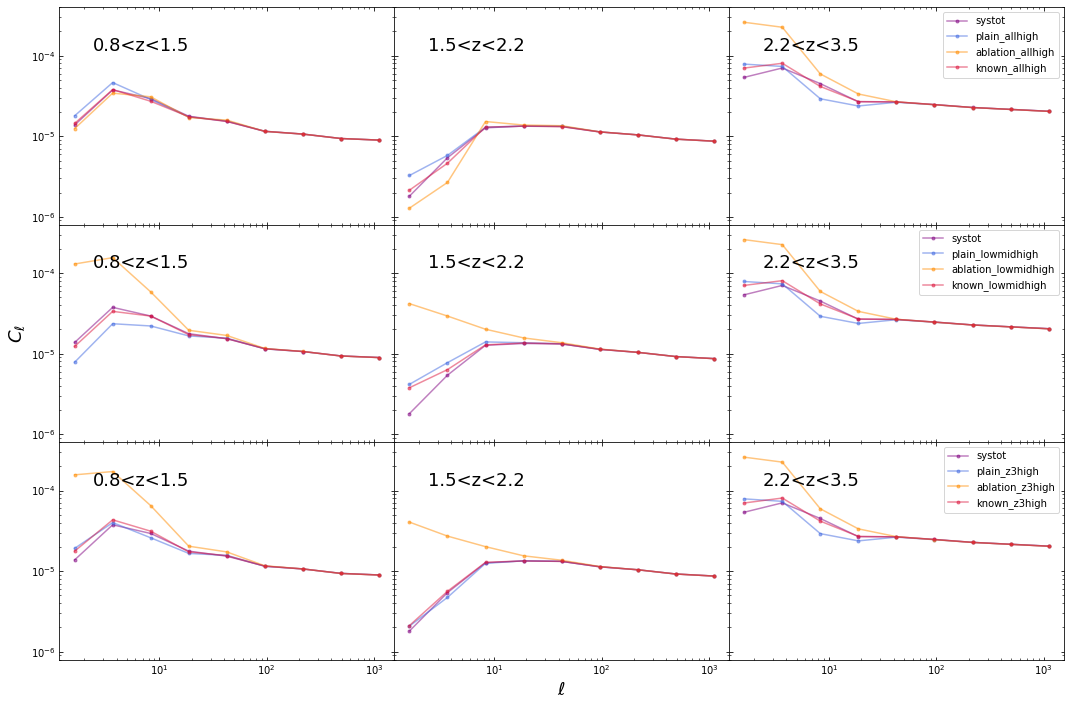

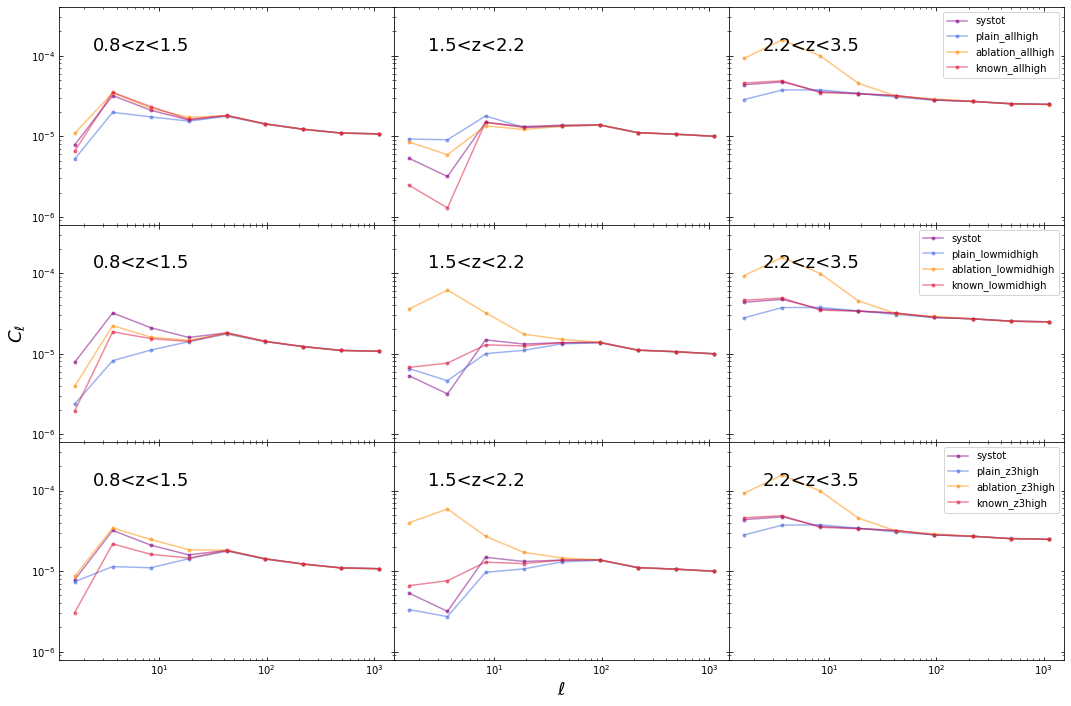

In [6]:
labels = {'low':'0.8<z<1.5',
         'high':'1.5<z<2.2',
         'zhigh':'2.2<z<3.5'}

sf = 1.0e5

path = '/B/Shared/mehdi/eboss/data/v7_2/0.3/clustering/'

caps = ['NGC', 'SGC']
samples = ['low', 'high', 'zhigh']
treatments = ['Systot',   'NN-plain', 'NN-ablation', 'NN-known']

models2z = ['systot',  'plain_allhigh', 'ablation_allhigh', 'known_allhigh']
models3z = ['systot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']
models4z = ['systot',  'plain_z3high', 'ablation_z3high', 'known_z3high']

mk = ['*', 's', '^', '>', 'o']
c = ['purple', 'royalblue', 'darkorange', 'crimson']

pdf = matplotlib.backends.backend_pdf.PdfPages(f'figs/clgg_NGC_SGC.pdf') 
pdf_i = 0

for cap in caps:
    
    fig, ax = plt.subplots(ncols=3, nrows=3, 
                           figsize=(18, 12), 
                           sharey=True, sharex=True)
    fig.subplots_adjust(wspace=0.0, hspace=0.0)
    ax = ax.flatten()            
        
    for jx, methods in enumerate([models2z, models3z, models4z]):

        for i, zrange in enumerate(samples):
            ix = i + jx*3
            for k,m in enumerate(methods):

                d = np.load(f'{path}cl_0.3_{cap}_{m}_{zrange}.npy', allow_pickle=True).item()

                lb, c_gg,_ = histogram(d['cl_gg']['l'], d['cl_gg']['cl'])

                ax[ix].plot(lb,
                            c_gg, 
                            ls='-', 
                            marker='.', 
                            alpha=0.5, 
                            label=m,
                            color=c[k])
                
            ax[ix].text(0.1, 0.8, labels[samples[i]], transform=ax[ix].transAxes, fontsize=18)
            if (ix > 0 ) & ((ix+1) % 3 == 0):
                ax[ix].legend() 

    for ix, axi in enumerate(ax):            

        ax[ix].set(xscale='log', yscale='log', ylim=(8.0e-7, 4.0e-4))
        ax[ix].tick_params(direction='in',
                           which='both', 
                           axis='both', 
                           right=True, top=True)
        if ix == 3:
            ax[ix].set_ylabel(r'$C_{\ell}$', fontsize=18)
        if ix == 7:
            ax[ix].set_xlabel(r'$\ell$', fontsize=18)
            
    pdf.savefig((pdf_i+1), bbox_inches='tight')
    pdf_i += 1
    print('.', end='')
pdf.close()

..................

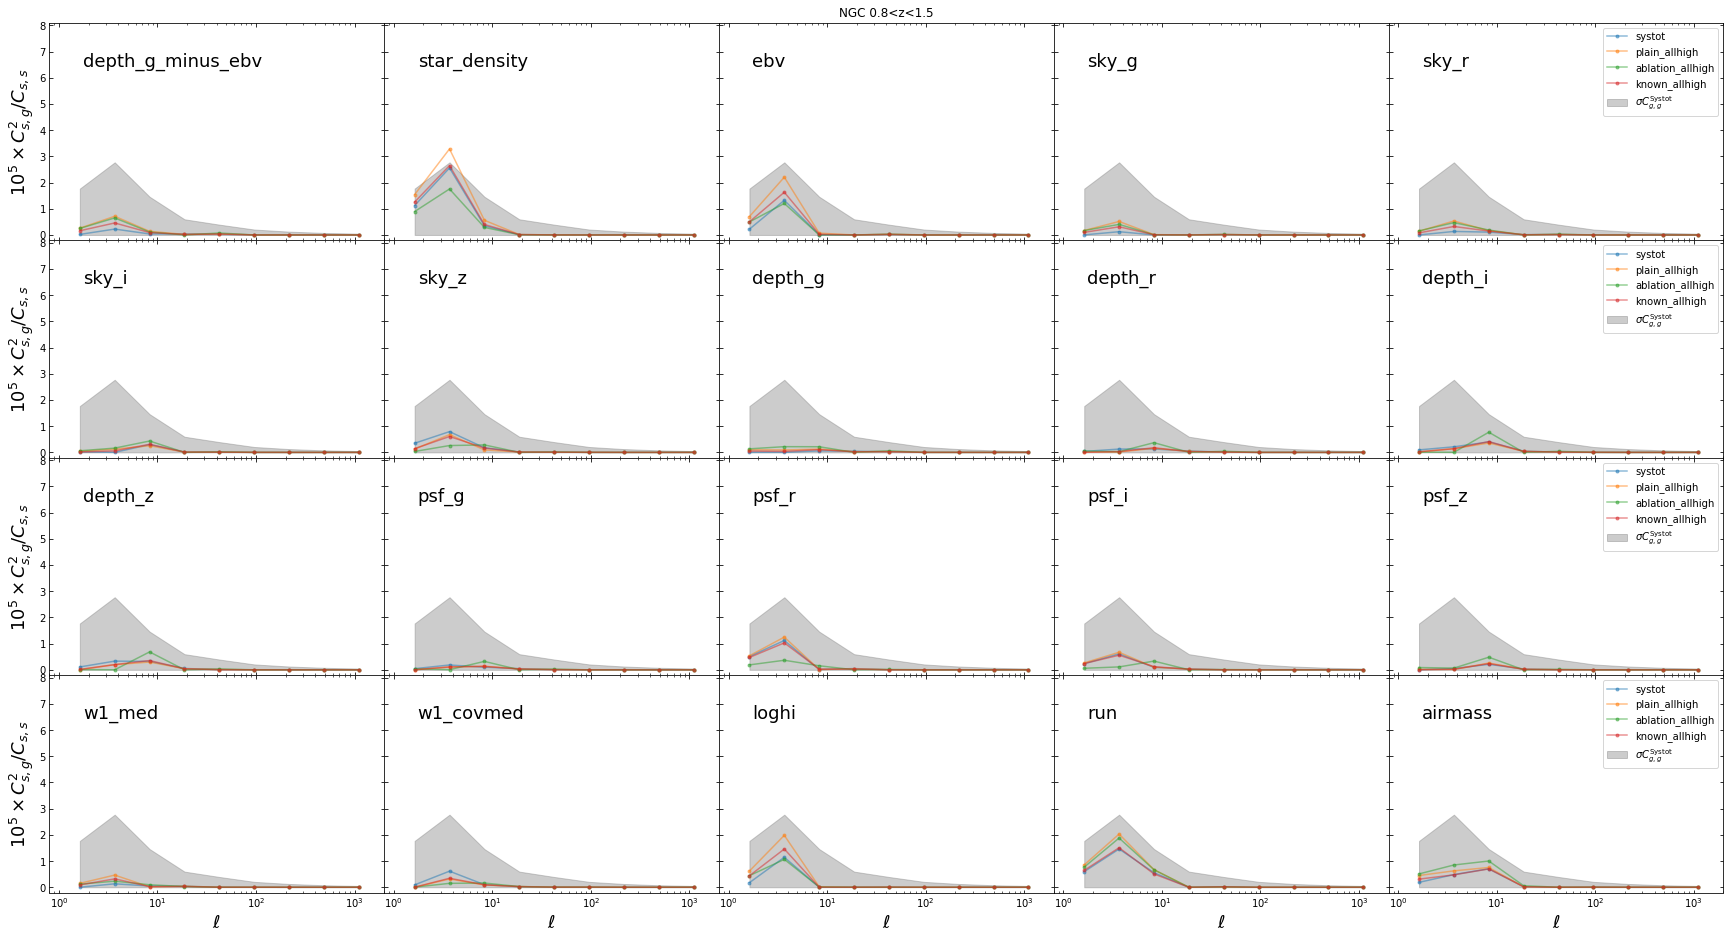

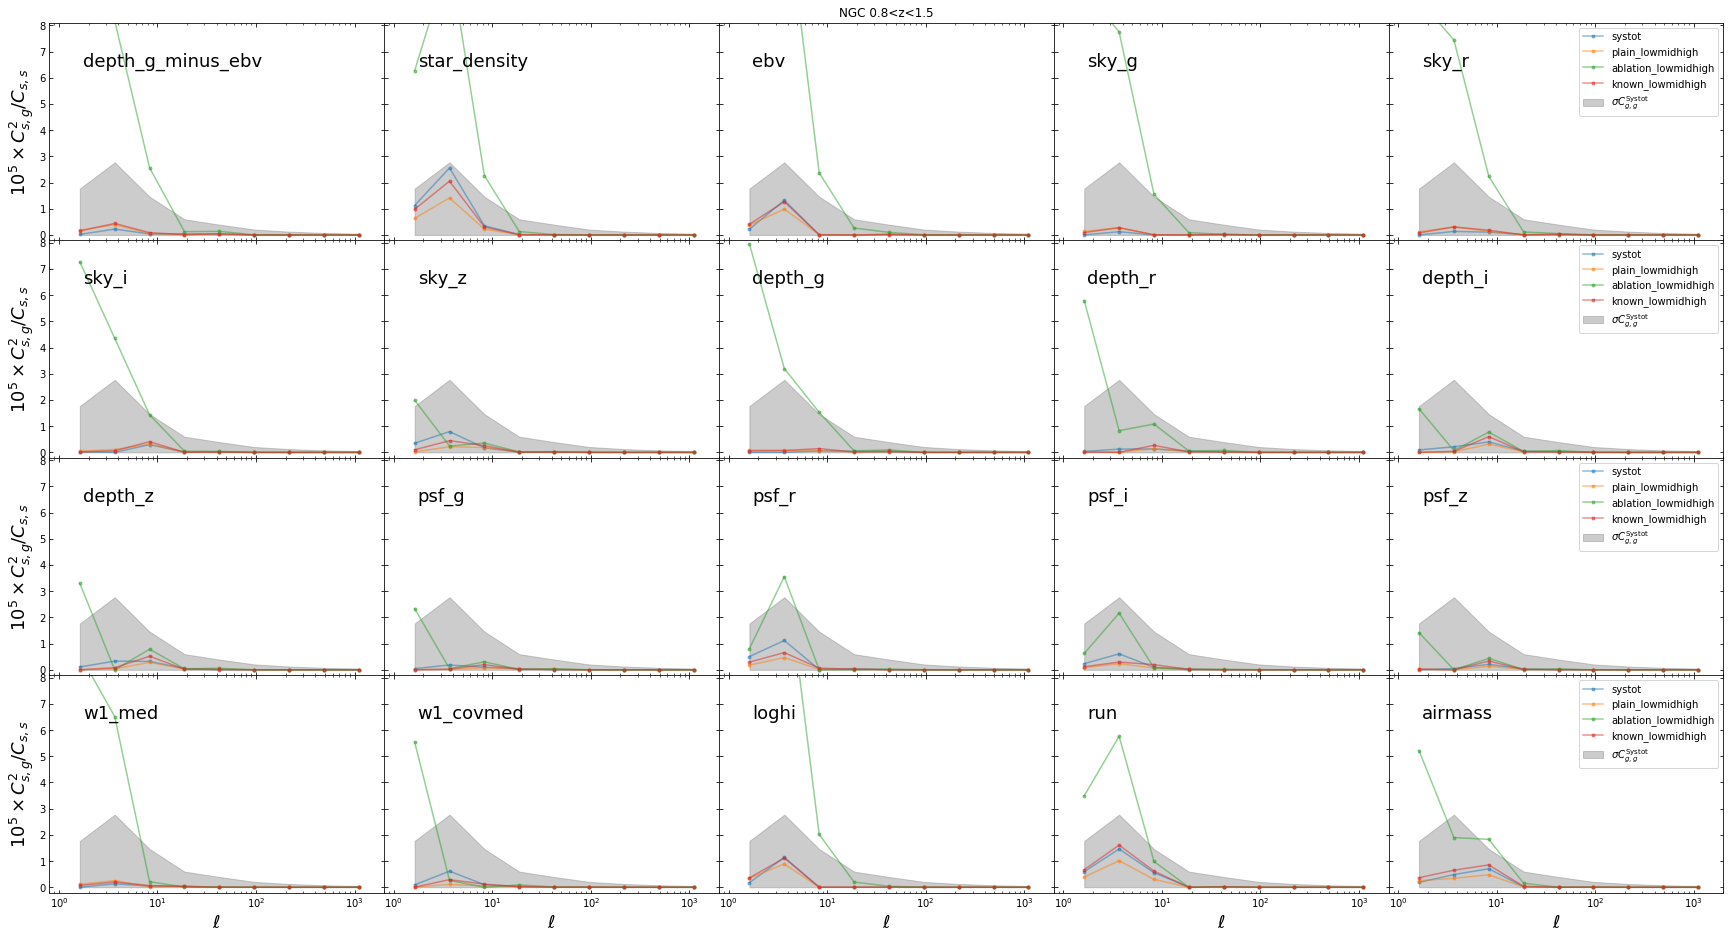

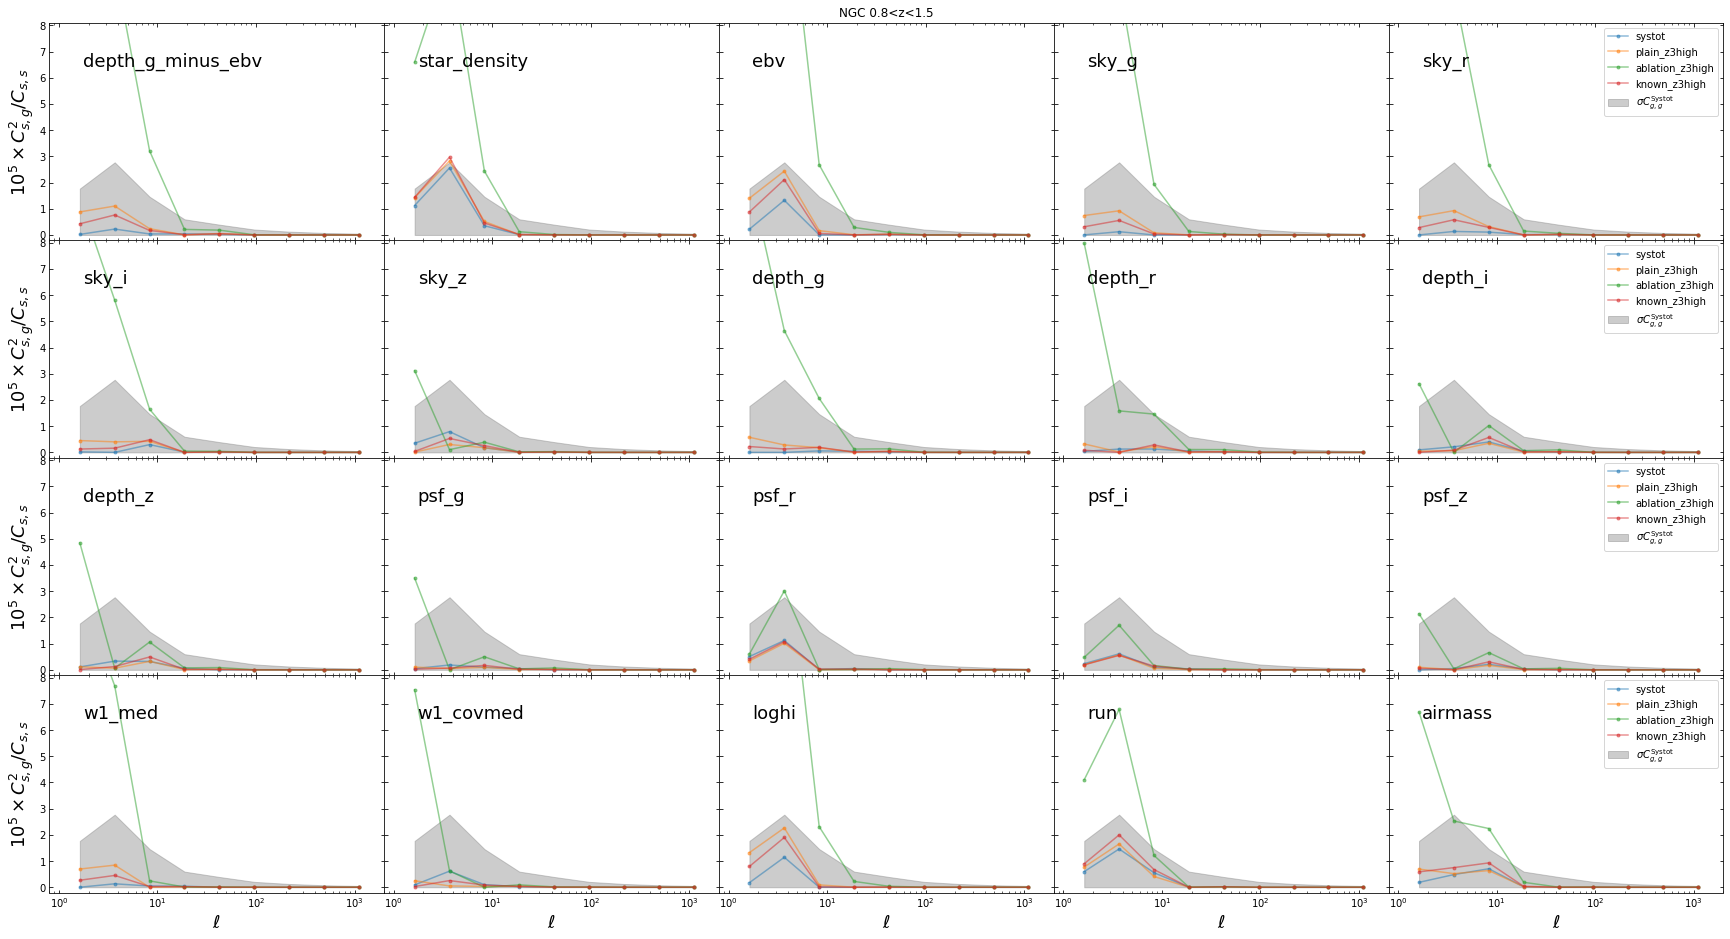

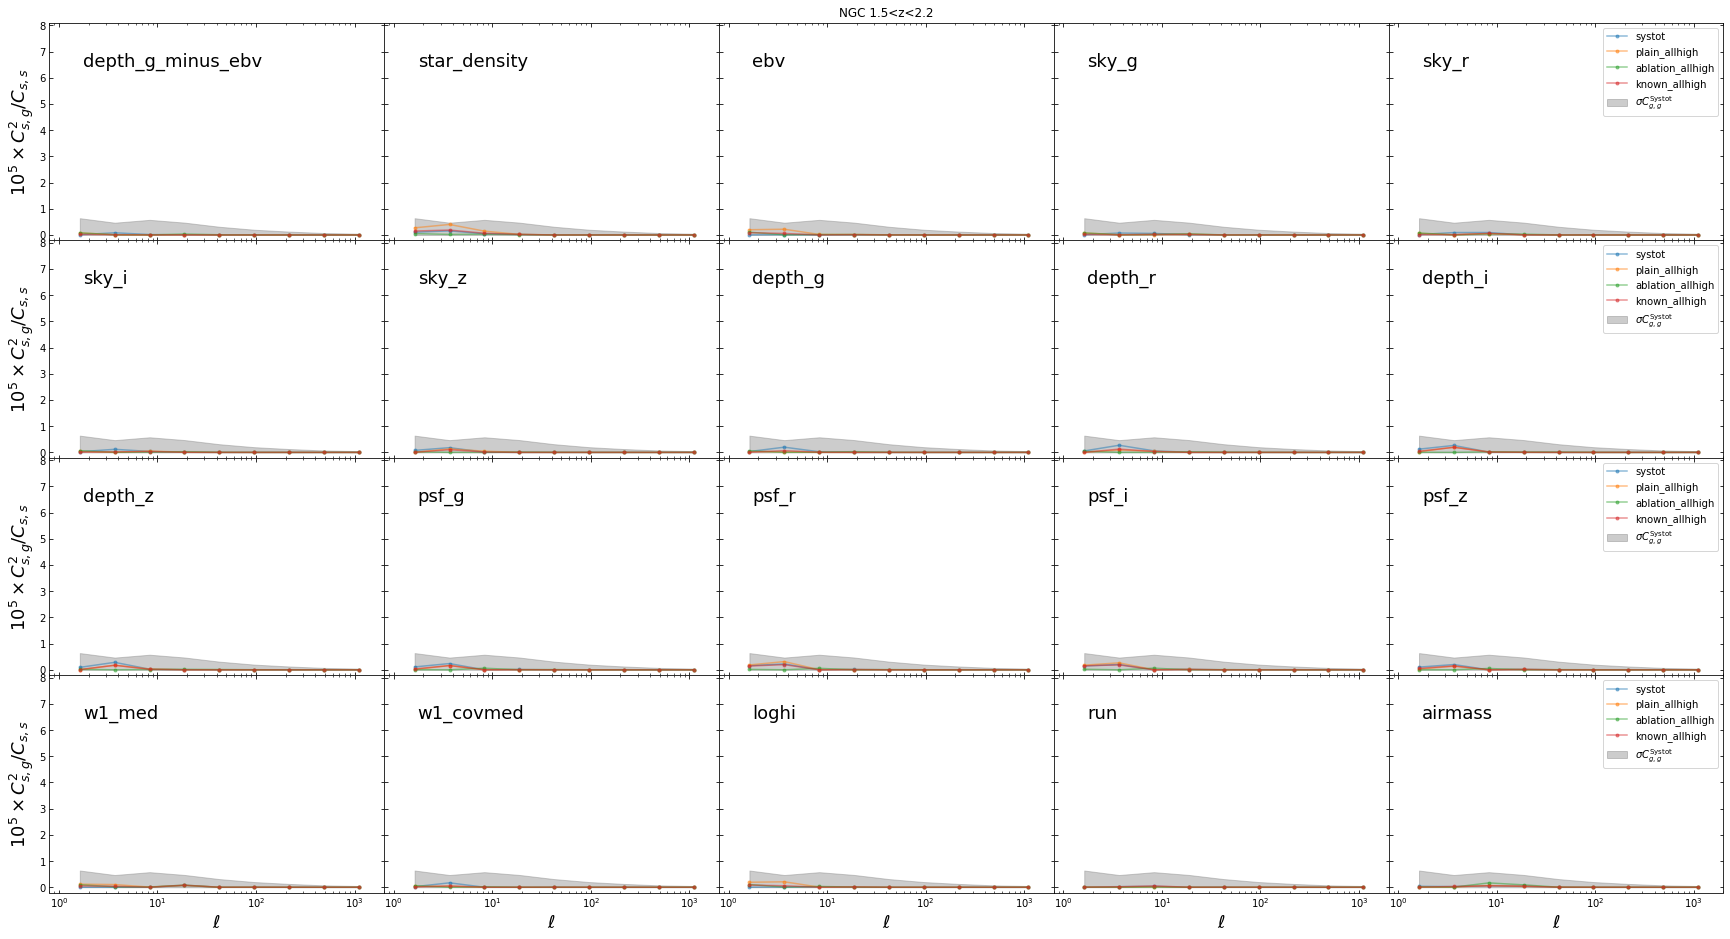

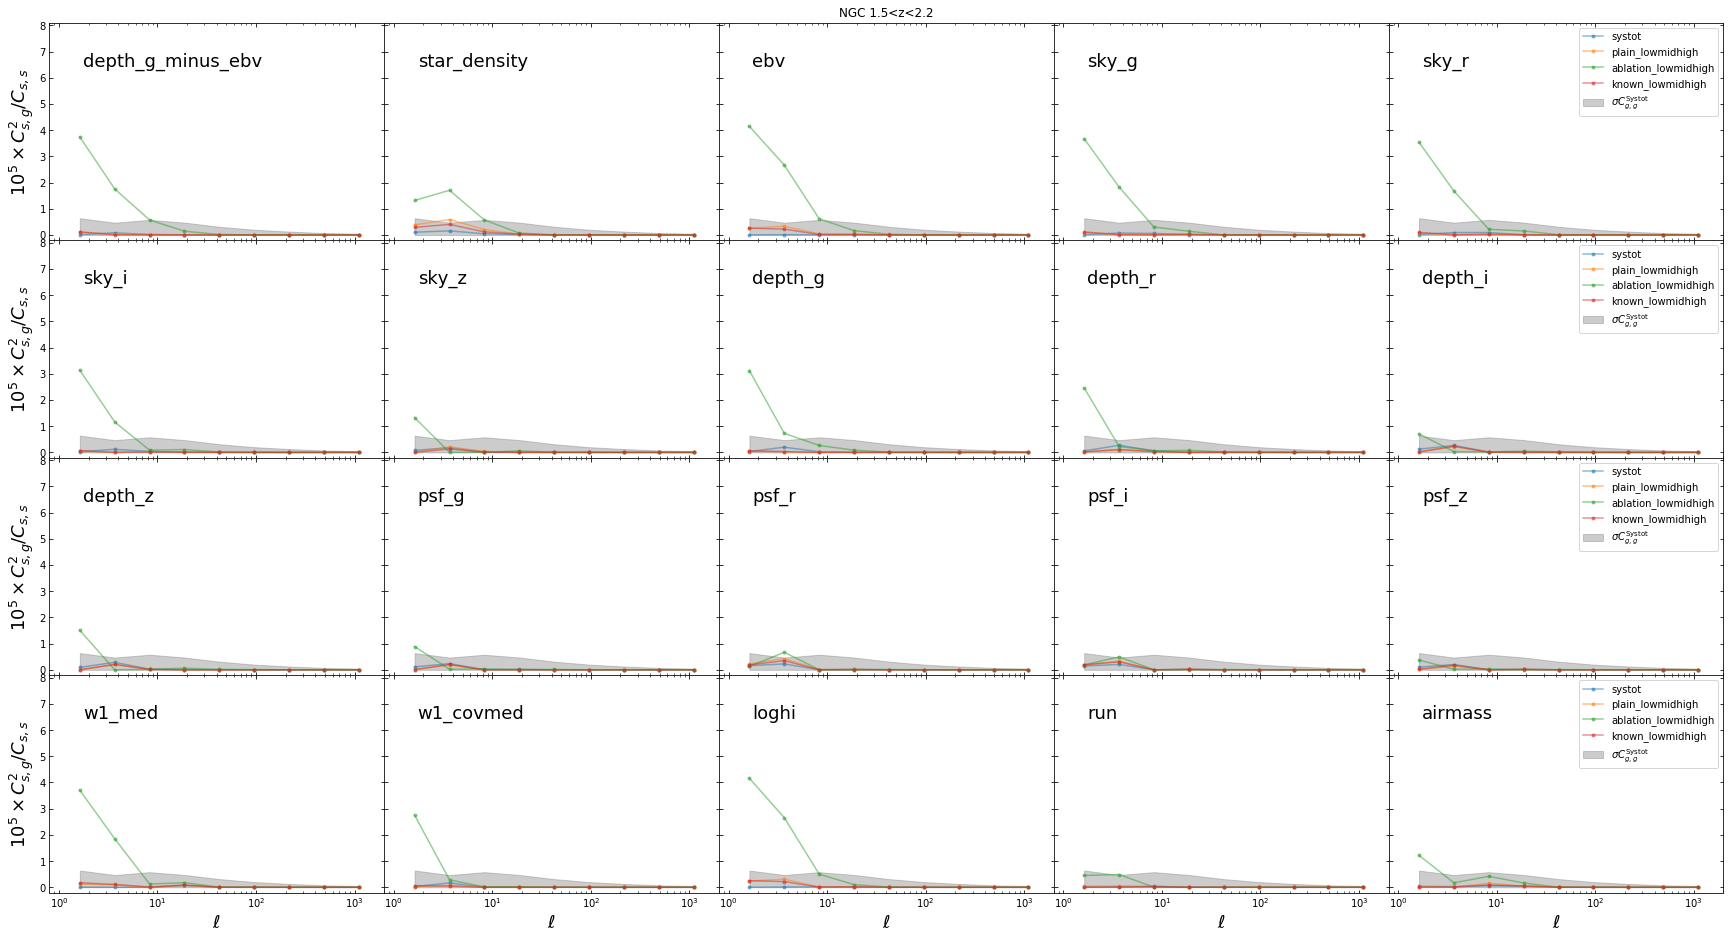

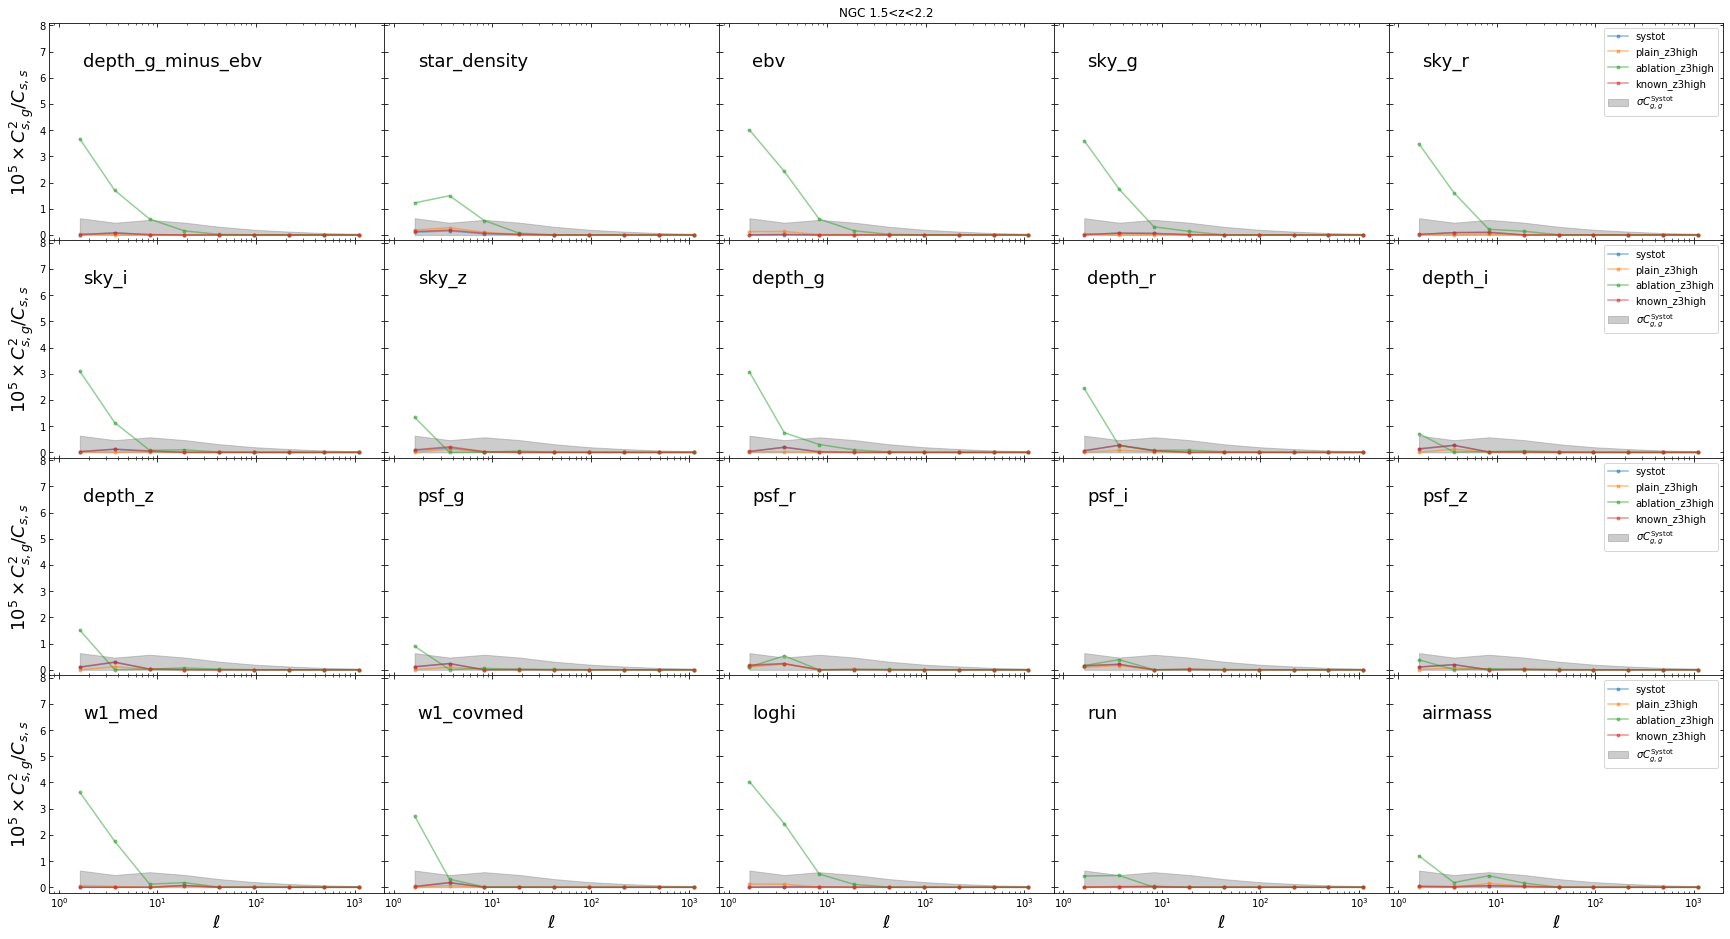

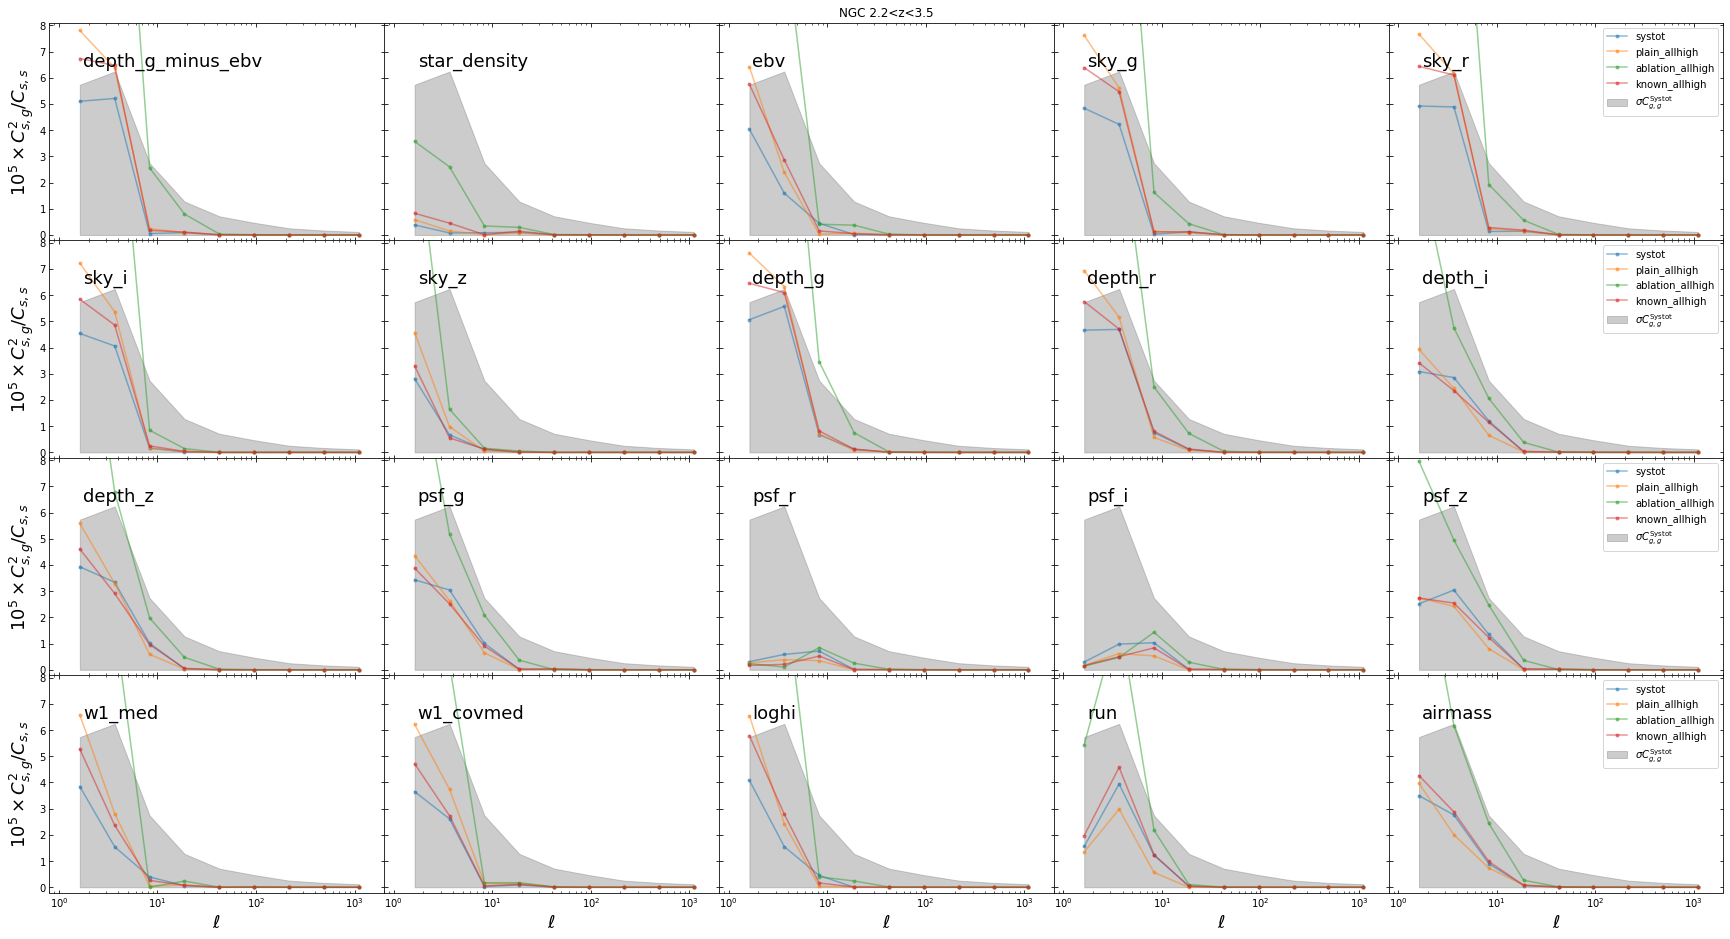

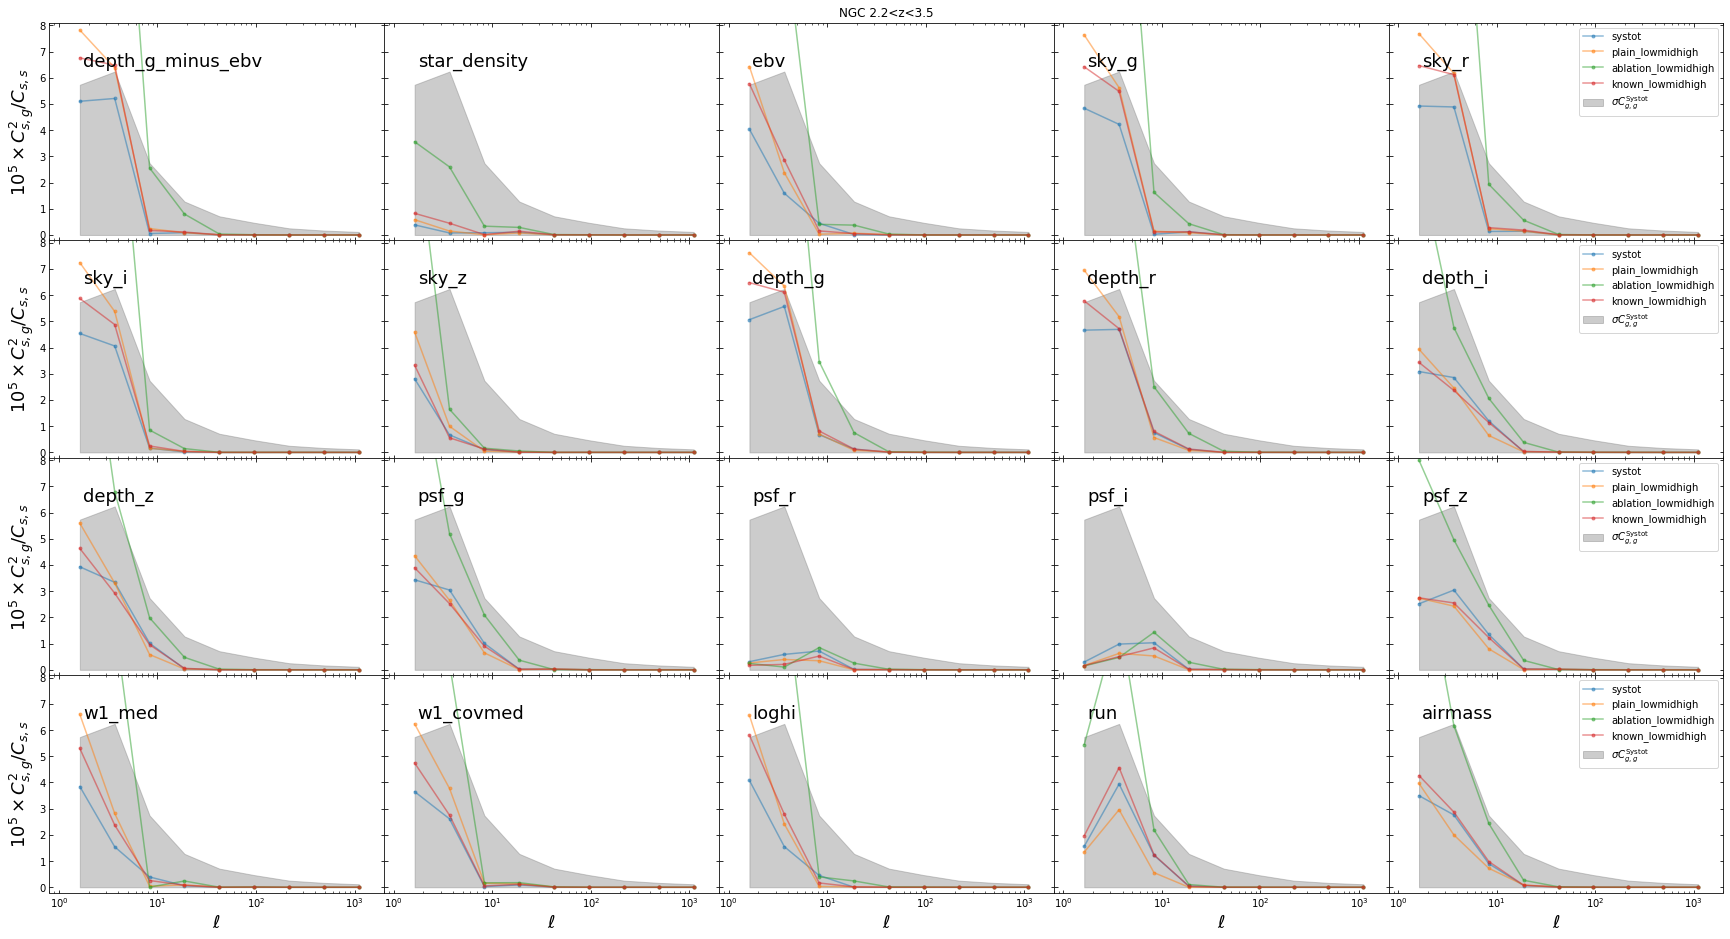

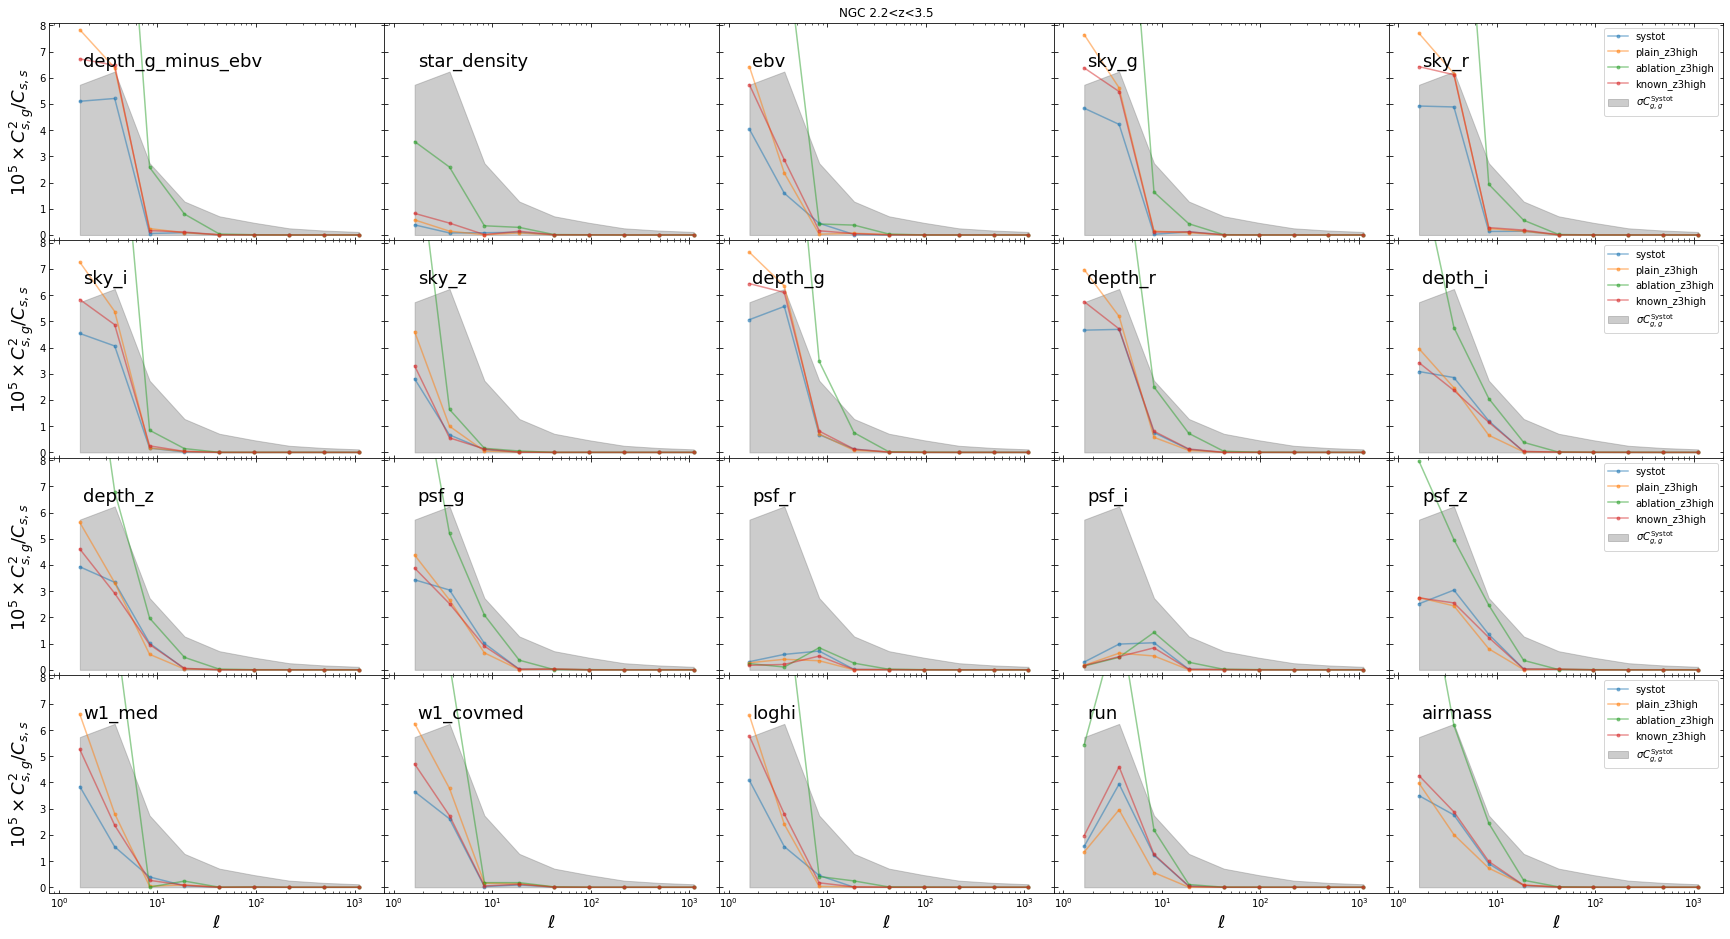

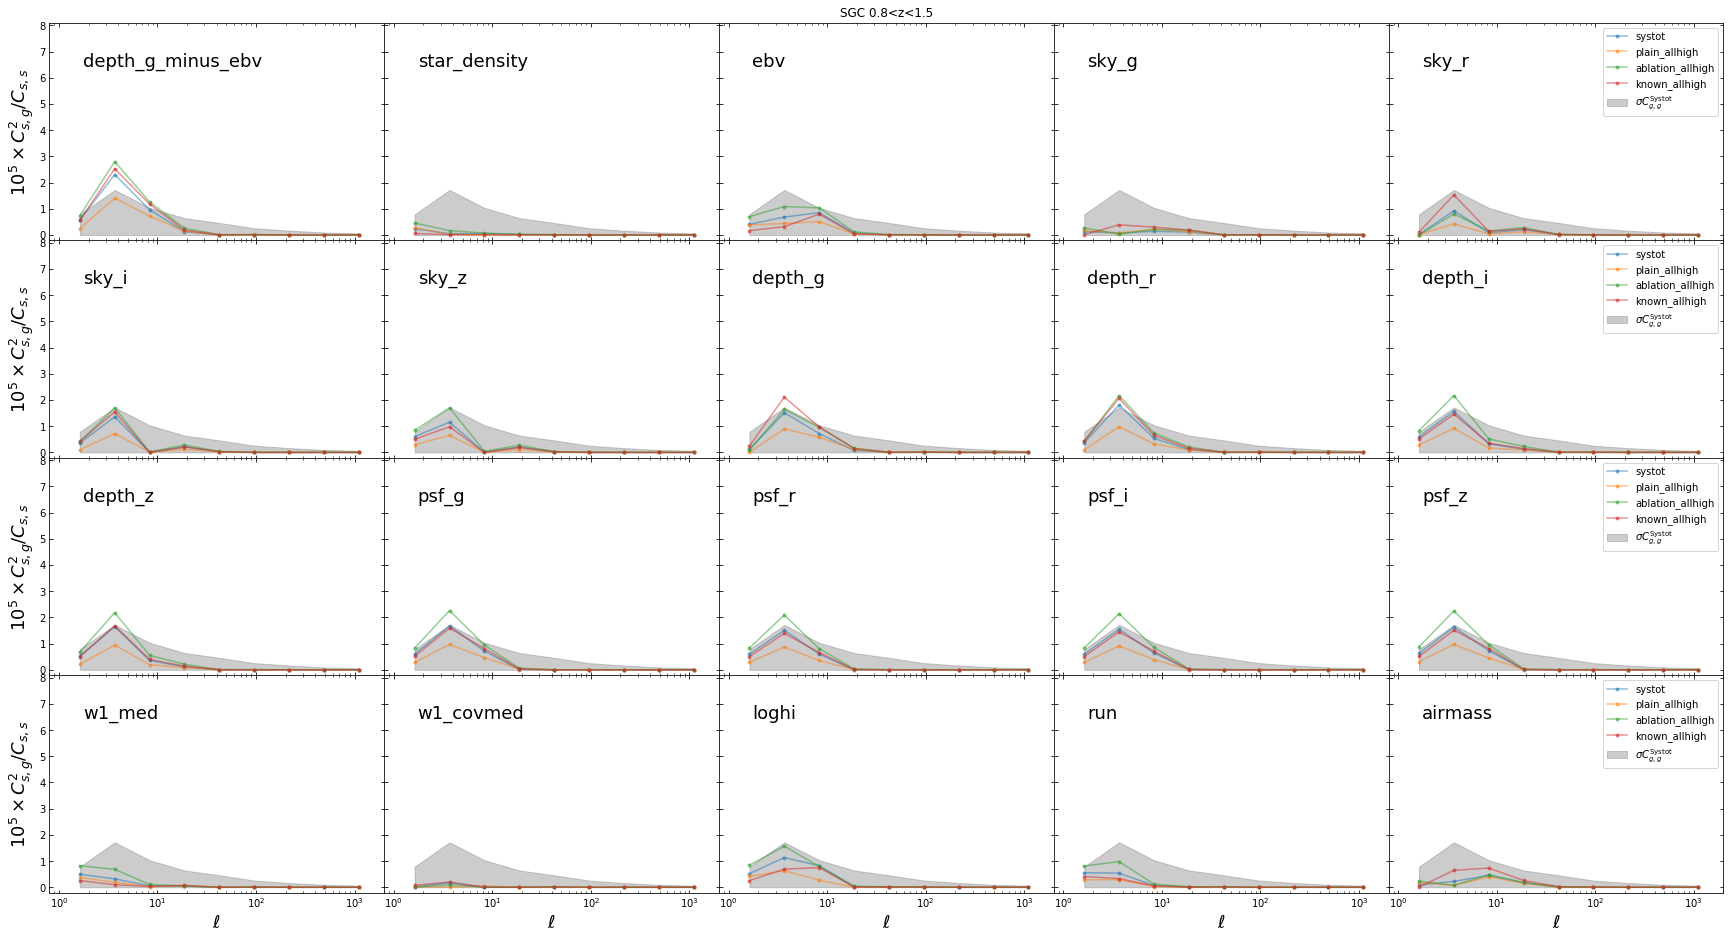

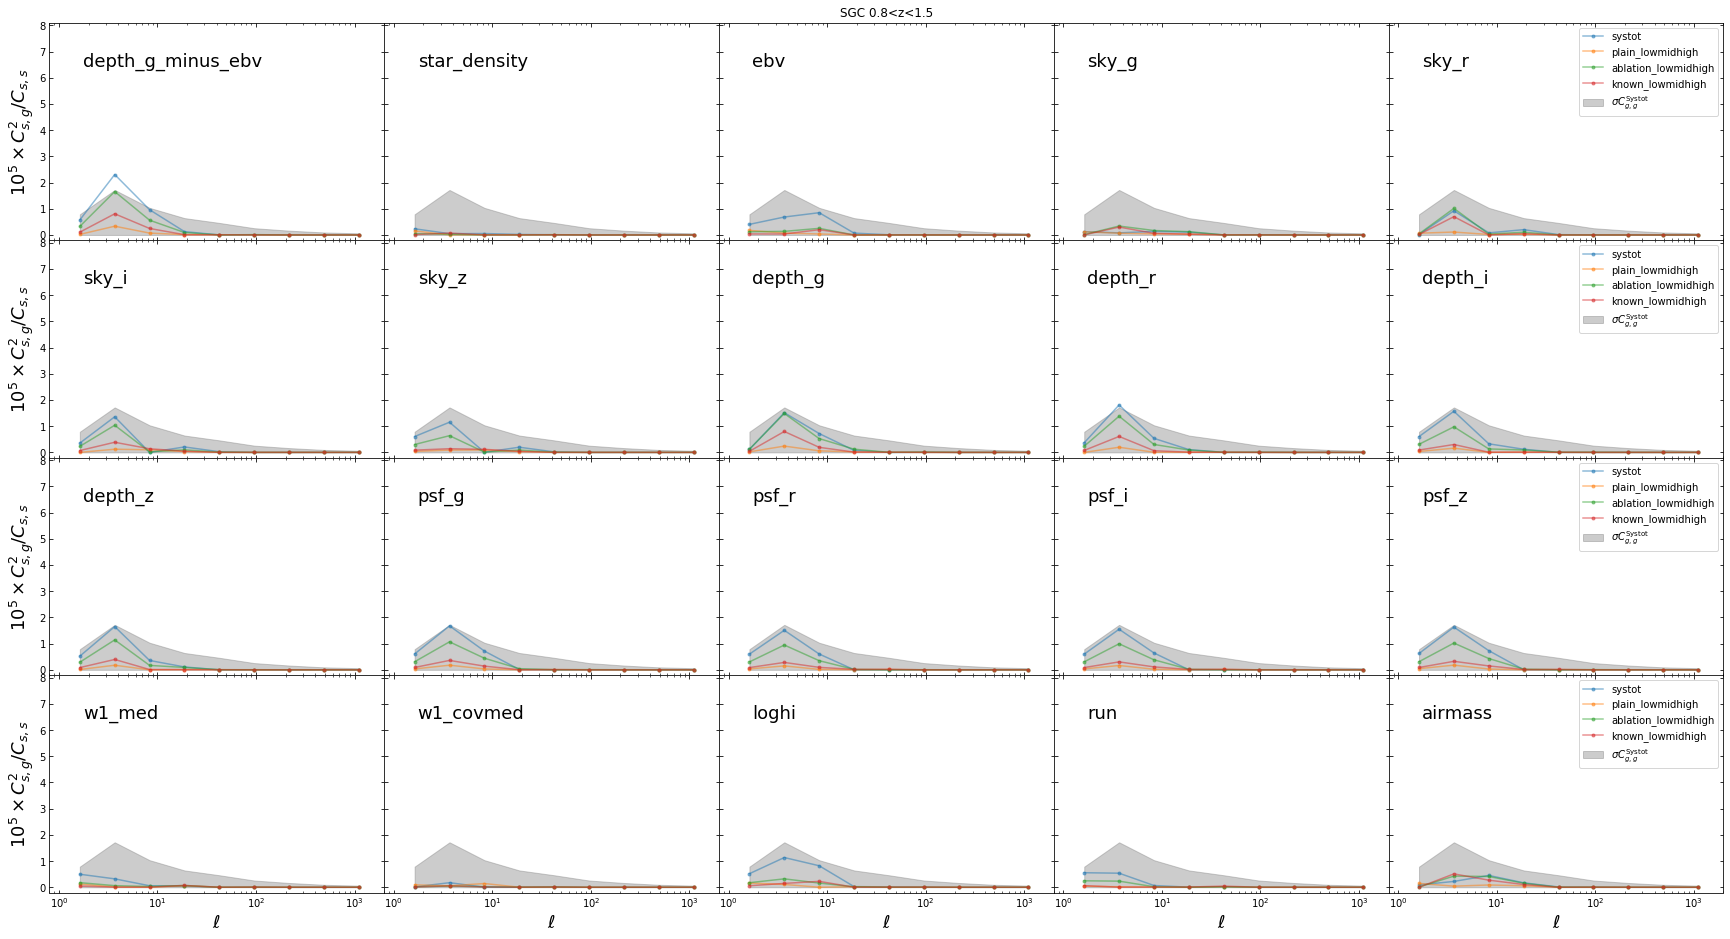

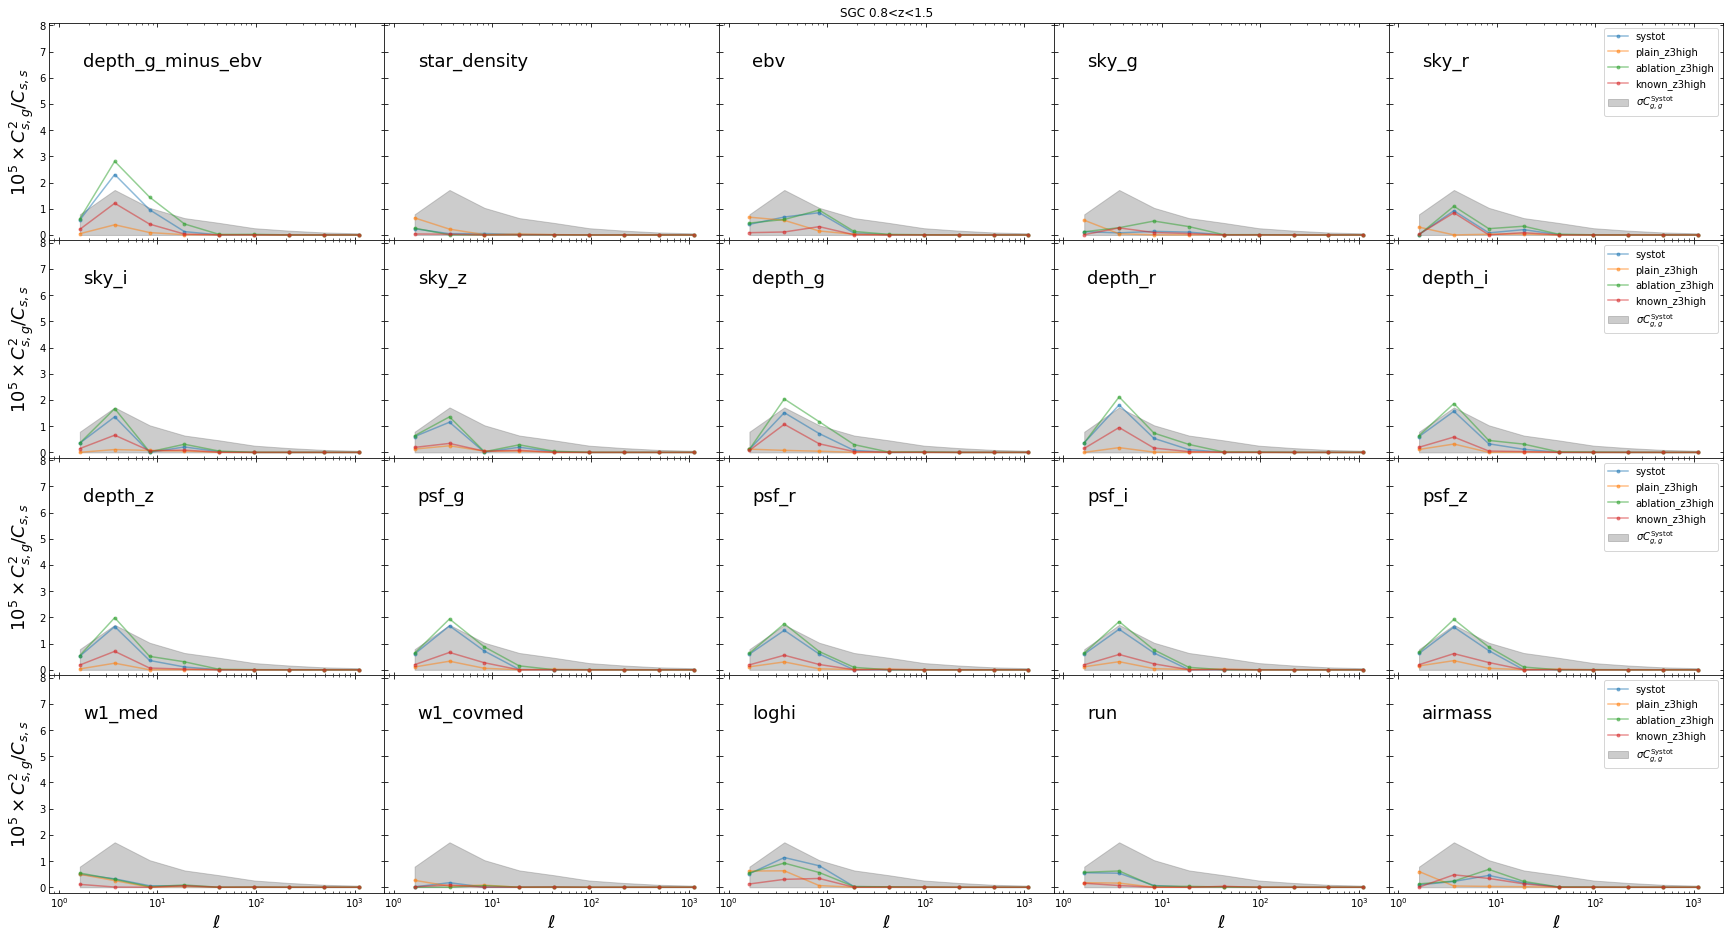

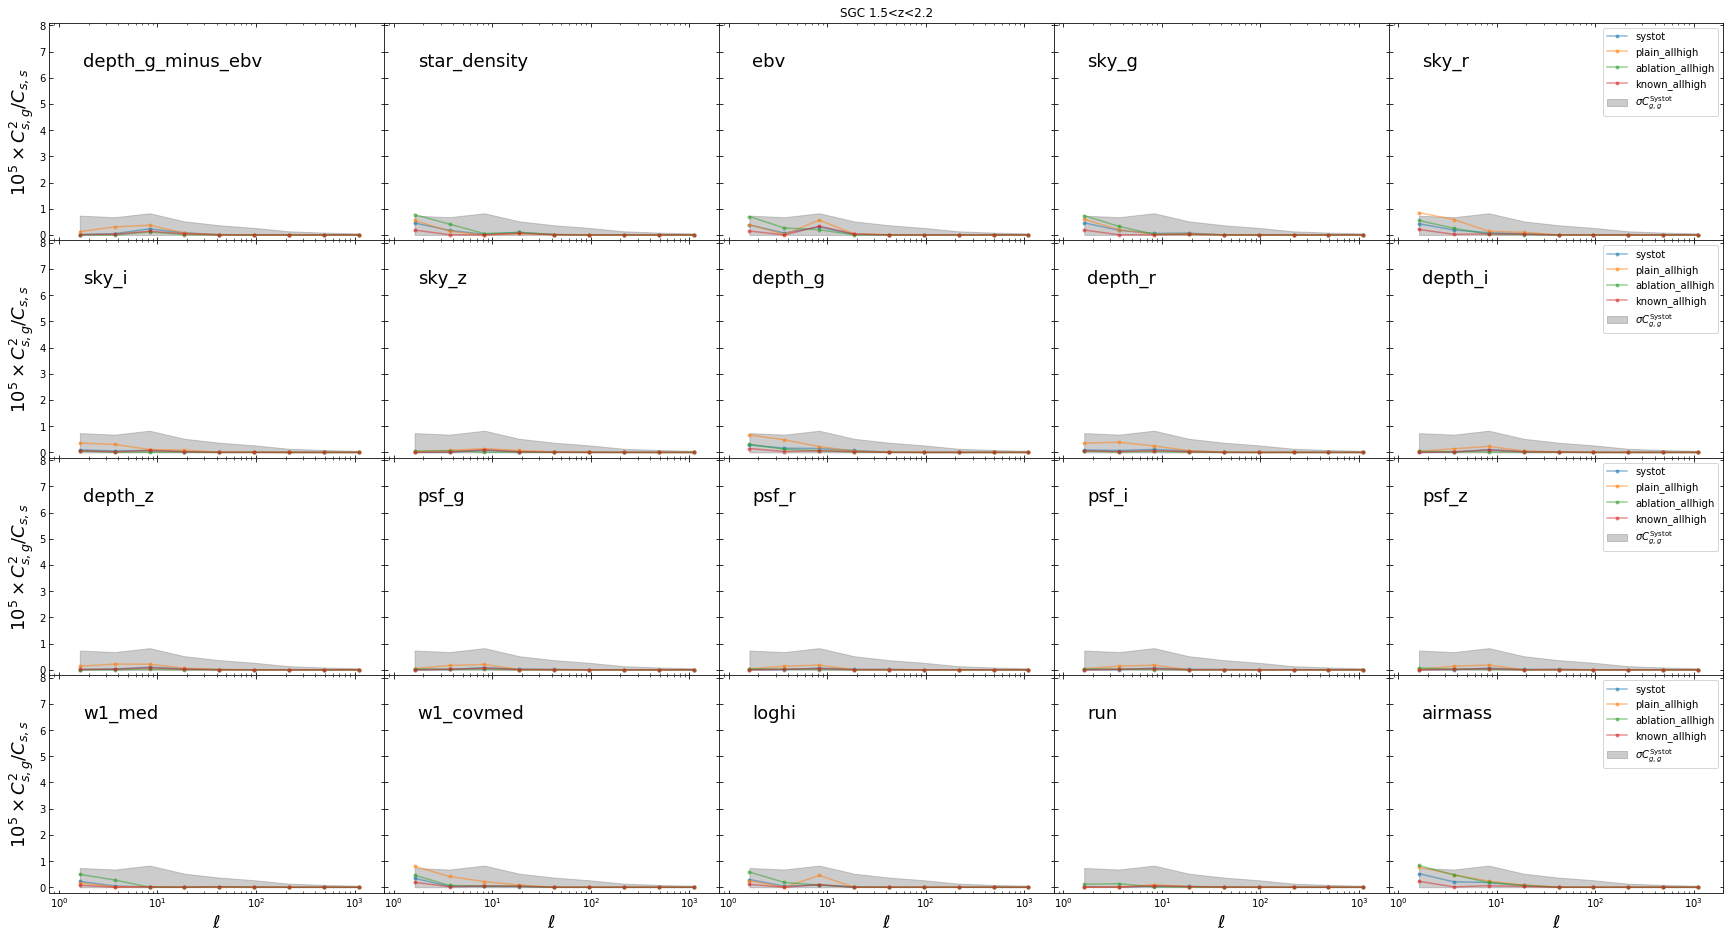

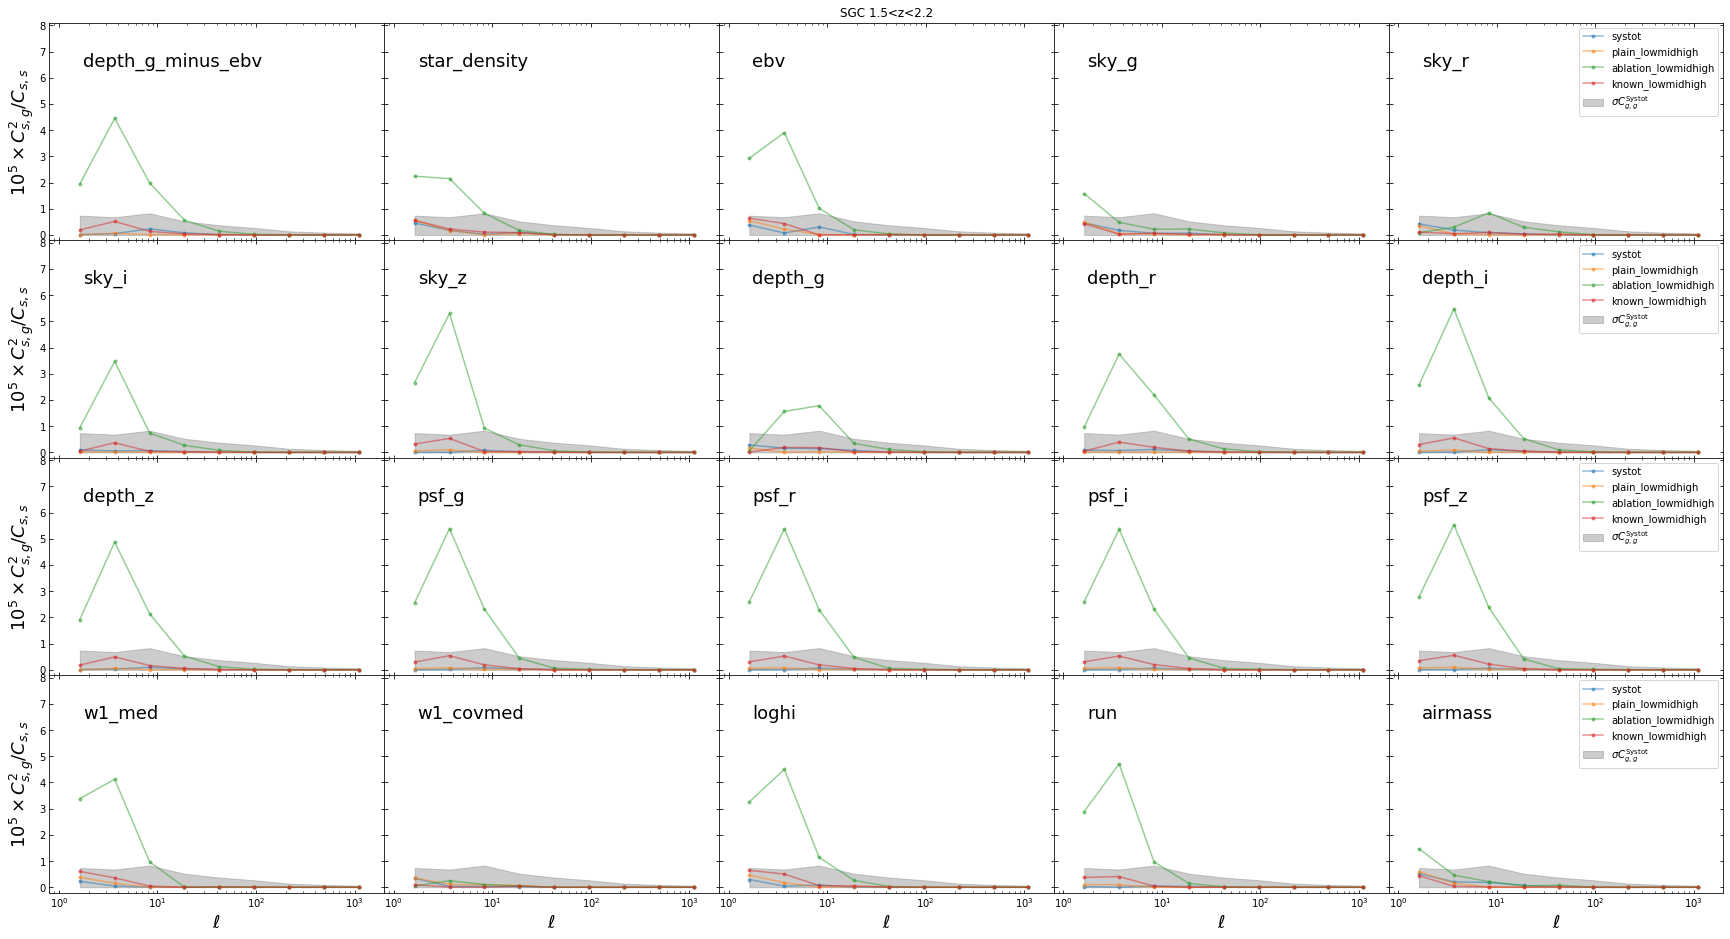

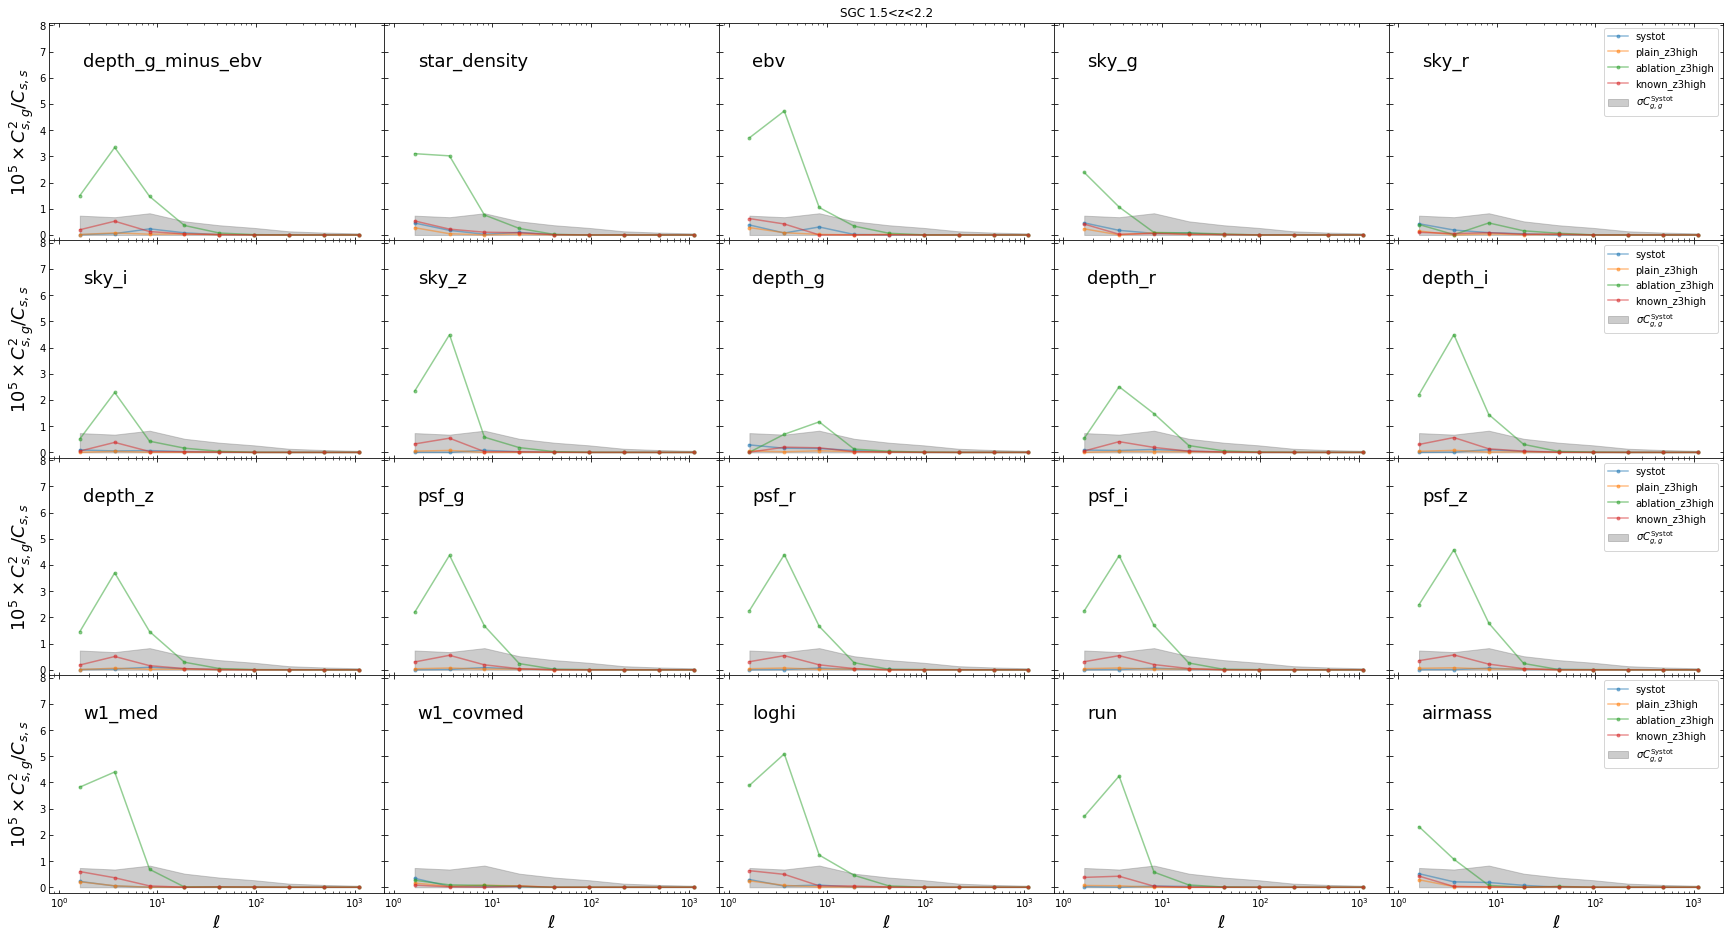

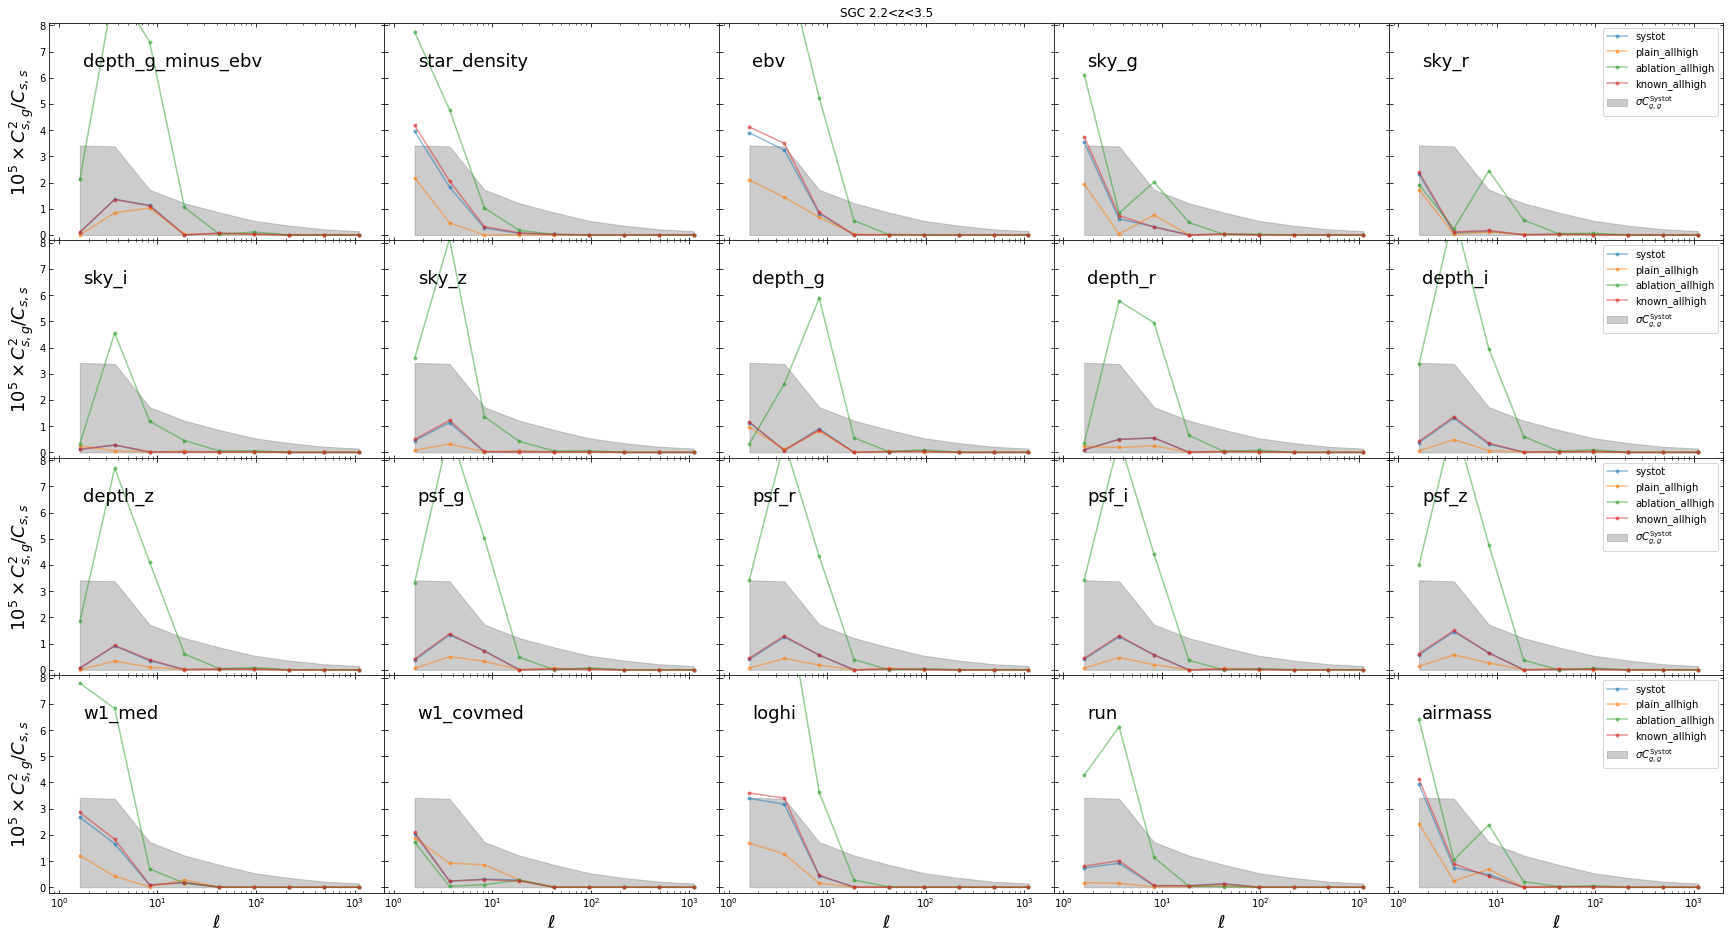

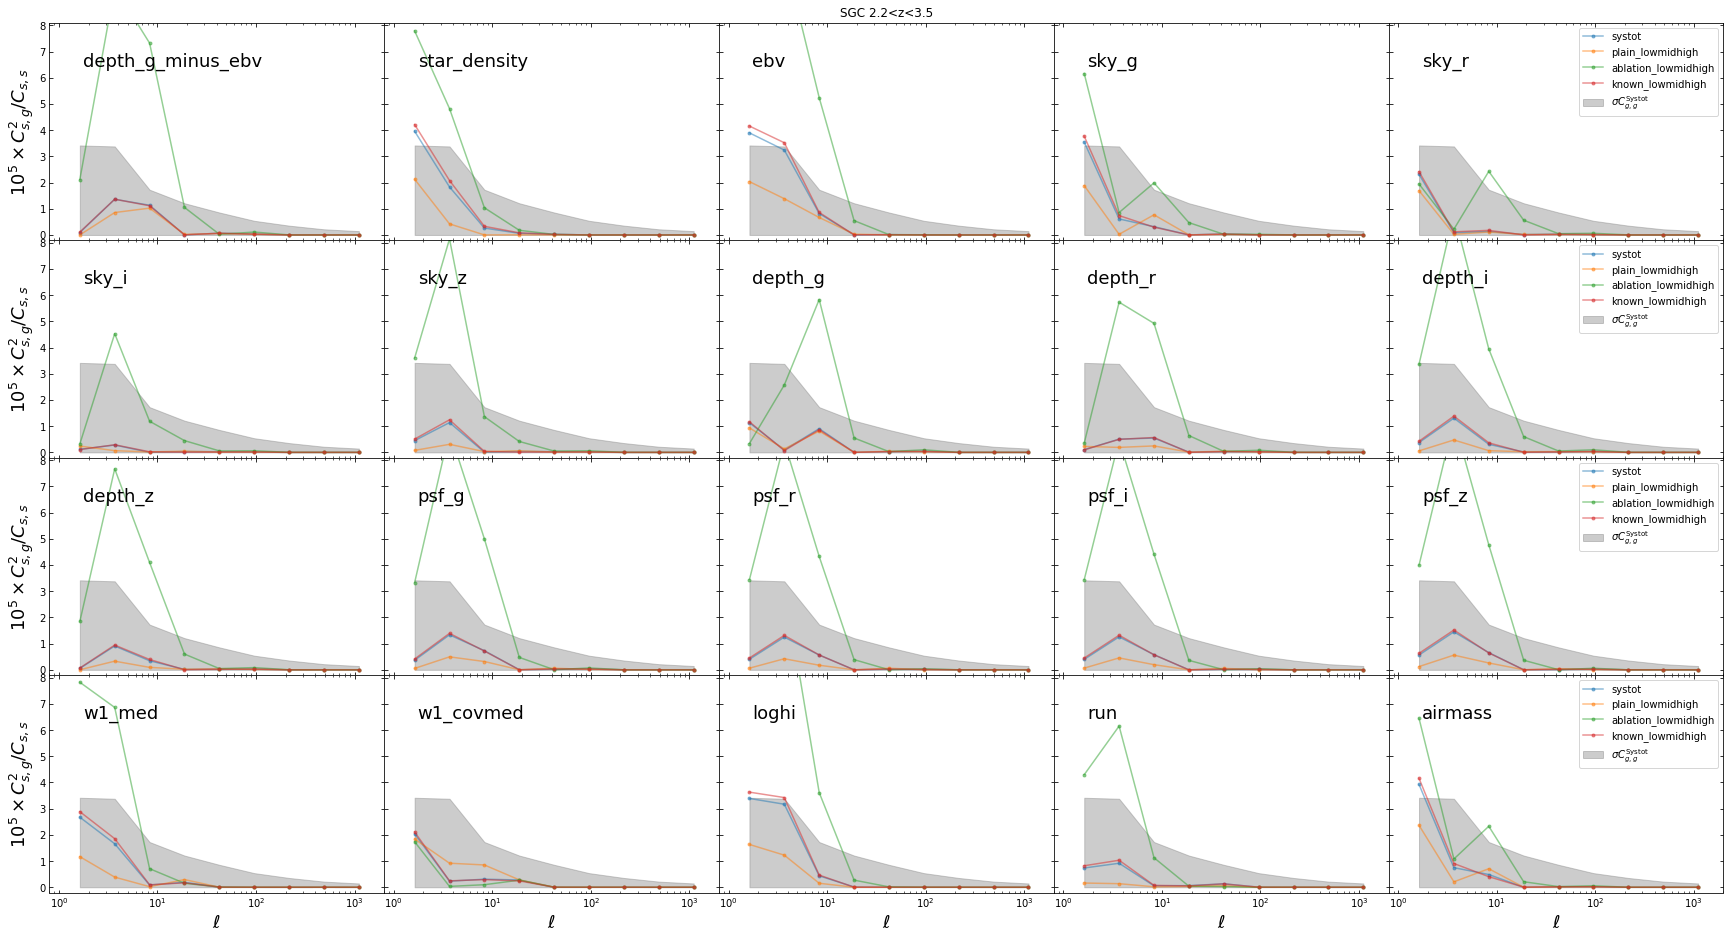

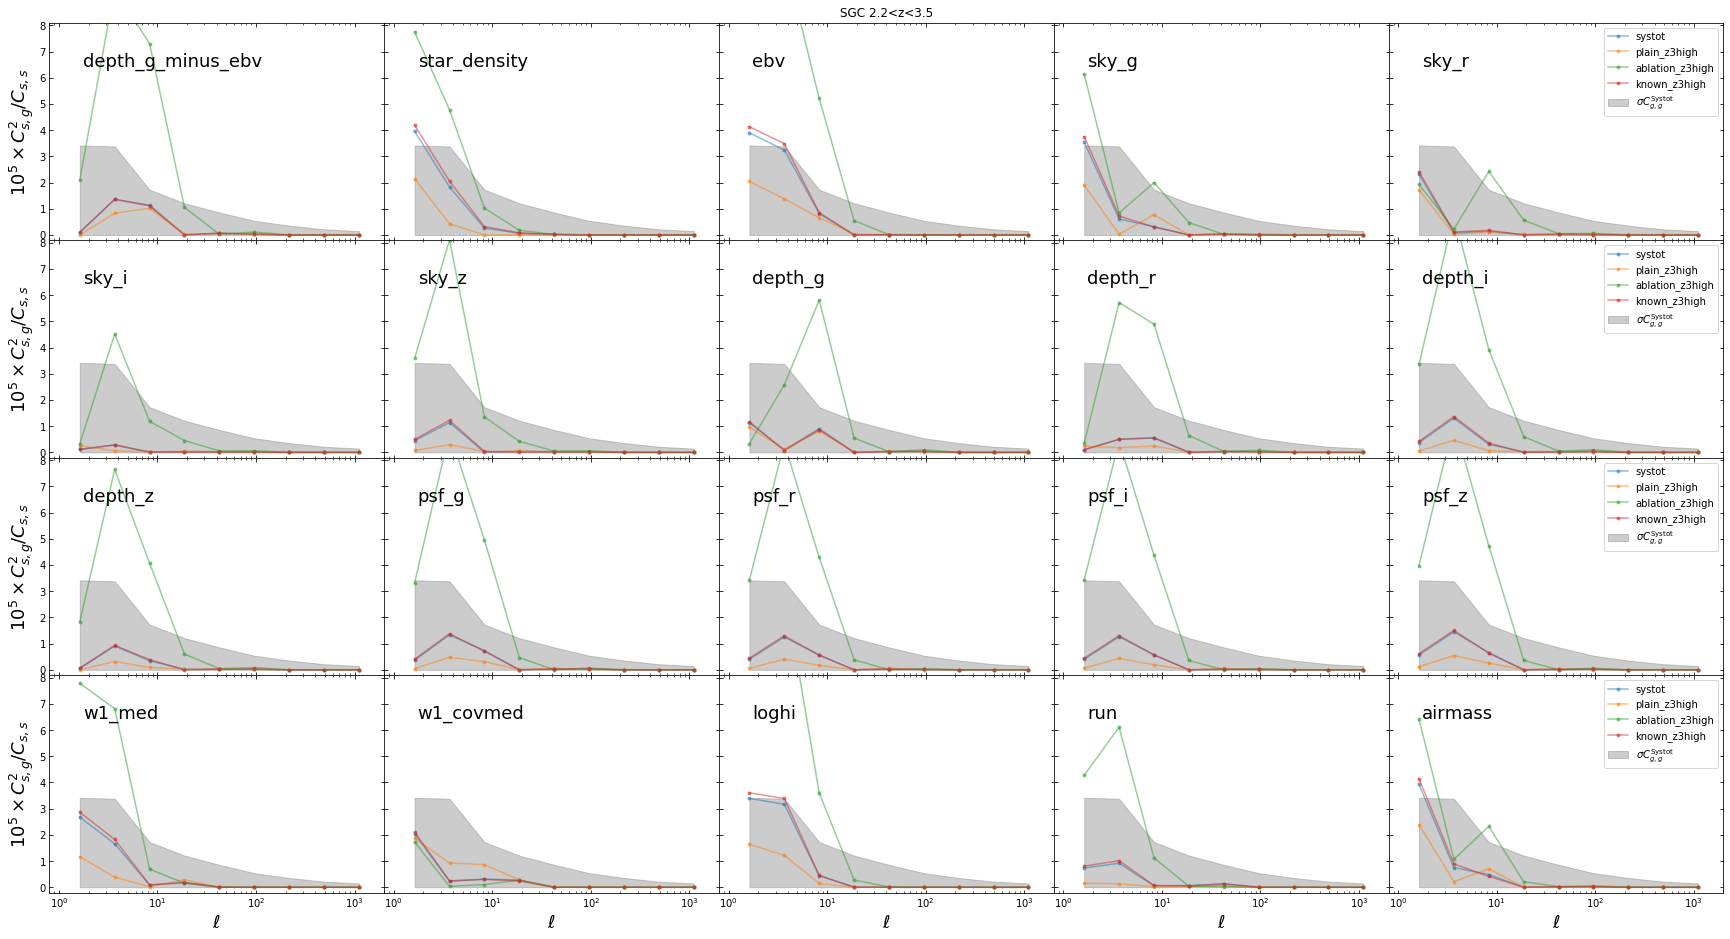

In [8]:
labels = {'low':'0.8<z<1.5',
         'high':'1.5<z<2.2',
         'zhigh':'2.2<z<3.5'}

sf = 1.0e5

path = '/B/Shared/mehdi/eboss/data/v7_2/0.3/clustering/'

caps = ['NGC', 'SGC']
samples = ['low', 'high', 'zhigh']
treatments = ['Systot',   'NN-plain', 'NN-ablation', 'NN-known']

models2z = ['systot',  'plain_allhigh', 'ablation_allhigh', 'known_allhigh']
models3z = ['systot',  'plain_lowmidhigh', 'ablation_lowmidhigh', 'known_lowmidhigh']
models4z = ['systot',  'plain_z3high', 'ablation_z3high', 'known_z3high']

mk = ['*', 's', '^', '>', 'o']
c = ['purple', 'royalblue', 'darkorange', 'crimson']

pdf = matplotlib.backends.backend_pdf.PdfPages(f'figs/cl_NGC_SGC.pdf') 
pdf_i = 0

for cap in caps:
    
    for zrange in samples:
        
        for methods in [models2z, models3z, models4z]:

            fig, ax = plt.subplots(ncols=5, nrows=4, 
                                   figsize=(30, 16), 
                                   sharey=True, sharex=True)
            fig.subplots_adjust(wspace=0.0, hspace=0.0)
            ax = ax.flatten()    

            for ix in range(20):

                for m in methods:

                    d = np.load(f'{path}cl_0.3_{cap}_{m}_{zrange}.npy', allow_pickle=True).item()

                    lb, c_sg,_ = histogram(d['cl_sg'][ix]['l'], d['cl_sg'][ix]['cl'])
                    lb, c_ss,_ = histogram(d['cl_ss'][ix]['l'], d['cl_ss'][ix]['cl'])
                    
                    ax[ix].plot(lb,
                                sf*c_sg*c_sg/c_ss, 
                                ls='-', marker='.', alpha=0.5, label=m)

                    if m == 'systot':
                        lb, c_gg, _ = histogram(d['cl_gg']['l'], d['cl_gg']['cl_error']) # fixme
                        ax[ix].fill_between(lb, 0, sf*c_gg, 
                                            color='grey', 
                                            label=r'$\sigma C_{g,g}^{\rm Systot}$', 
                                            alpha=0.4)

                                
                ax[ix].text(0.1, 0.8, cols_eboss_mocks_qso[ix], 
                            transform=ax[ix].transAxes, fontsize=18)
                if (ix > 0 ) & ((ix+1) % 5 == 0):
                    ax[ix].legend() 

                

            for ix, axi in enumerate(ax):            
                #ax[ix].legend(title=cols_eboss_mocks_qso[ix])                
                ax[ix].set(xscale='log')
                ax[ix].tick_params(direction='in', which='both', axis='both', right=True, top=True)
                
                if ix%5==0:
                    ax[ix].set_ylabel(r'$10^{5}\times C_{s,g}^{2} / C_{s,s}$', fontsize=18)
                if ix==2:
                    ax[ix].set_title(' '.join([cap, labels[zrange]]))
                if ix >= 15:
                    ax[ix].set_xlabel(r'$\ell$', fontsize=18)
            ax[0].set_xlim(0.8, 2.0e3)
            ax[0].set_ylim(-.2, 8.1)
            pdf.savefig((pdf_i+1), bbox_inches='tight')
            pdf_i += 1
            print('.', end='')
pdf.close()

# mocks

In [25]:
path = '/B/Shared/mehdi/eboss/mocks/0.3/'
pk_dict = {}

for cont in ['null', 'contaminated']:
    for model in ['ablation', 'known', 'plain', 'nowsys', 'systot', 'truth']:
        
        if (cont == 'null') & (model == 'nowsys'):
            continue
        
        if (cont == 'contaminated') & (model == 'truth'):
            continue
        
        for zsplit in ['all', 'lowmid', 'z3']:
            
            if (model in ['nowsys', 'systot', 'truth']) & (zsplit != 'all'):
                continue
            
            pk0 = []
            pk2 = []
            
            for i in range(1,10):                
                pktxt = f'{path}NGC_{i:04d}_{cont}/pk_QSO_NGC_v7_0.3_{model}_{zsplit}_{i:04d}_{cont}_512_standard.txt'

                pkdata, shotnoise = readnbodykit(pktxt)
                pk0.append(pkdata[:,2]-shotnoise)
                pk2.append(pkdata[:,3])
            
            name = '_'.join([cont, model, zsplit])
            pk_dict[name] = (pkdata[:, 0], np.mean(pk0, axis=0), np.mean(pk2, axis=0))
            print(name)

null_ablation_all
null_ablation_lowmid
null_ablation_z3
null_known_all
null_known_lowmid
null_known_z3
null_plain_all
null_plain_lowmid
null_plain_z3
null_systot_all
null_truth_all
contaminated_ablation_all
contaminated_ablation_lowmid
contaminated_ablation_z3
contaminated_known_all
contaminated_known_lowmid
contaminated_known_z3
contaminated_plain_all
contaminated_plain_lowmid
contaminated_plain_z3
contaminated_nowsys_all
contaminated_systot_all


In [26]:
colors = {}
for i, key in enumerate(pk_dict.keys()):
    colors[key] = plt.cm.jet(i/22)

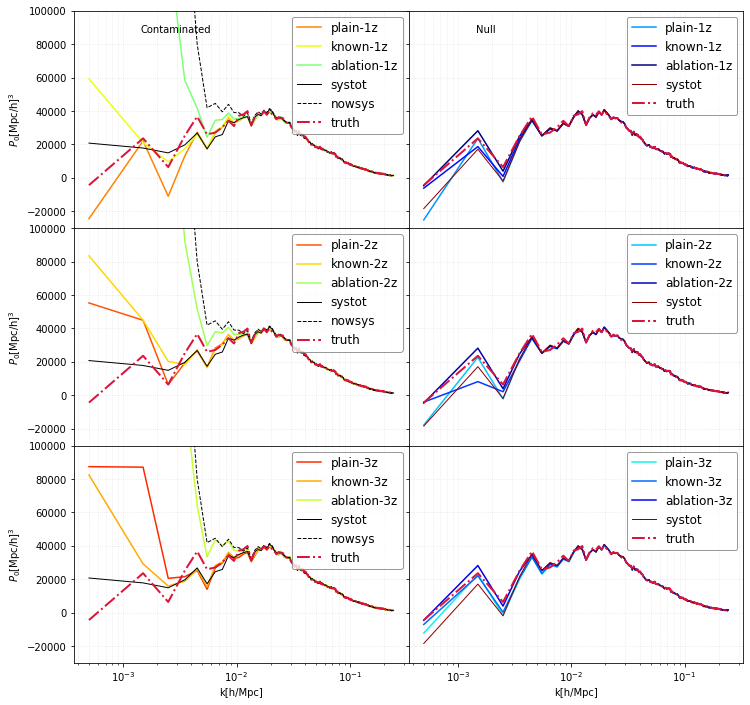

In [27]:
fig, ax = plt.subplots(ncols=2, 
                       nrows=3,
                       figsize=(12, 12), 
                       sharey=True, sharex=True)
ax = ax.flatten()
fig.subplots_adjust(hspace=0, wspace=0)


# -- draw the nn-based
zsplits_l = {'all':'1z',
             'lowmid':'2z',
             'z3':'3z'}

zsplits= ['all', 'lowmid', 'z3']
for j,zsplit in enumerate(zsplits):
    
    for i, model in enumerate(['plain', 'known', 'ablation']):
        ix = 2*j
        
        label = '-'.join([model, zsplits_l[zsplit]])
        name = f'contaminated_{model}_{zsplit}'
        ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)

        name = f'null_{model}_{zsplit}'
        ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color=colors[name], label=label)       

for j in range(3):
    ix = 2*j        
    
    name = f'contaminated_systot_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='systot', lw=1)
    name = f'contaminated_nowsys_all'
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], color='k', label='nowsys', ls='--', lw=1)
    

    name = f'null_systot_all'
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], color='#8a0000', label='systot', lw=1)
    
    name = f'null_truth_all'
    kw = dict(color='crimson',  label='truth', ls='-.', lw=2)
    ax[ix].plot(pk_dict[name][0], pk_dict[name][1], **kw)    
    ax[ix+1].plot(pk_dict[name][0], pk_dict[name][1], **kw)

       
for i, axi in enumerate(ax):
    axi.set_xscale('log')
    axi.set_ylim(-3.0e4, 1.0e5)
    axi.grid(True, ls=':', color='grey', alpha=0.2, which='both')
    axi.legend(loc='upper right', fontsize=12, facecolor='w', edgecolor='grey')
    
    if i%2==0:
        axi.set_ylabel(r'$P_{0}$[Mpc/h]$^{3}$')
        
    if i > 3:
        axi.set_xlabel(r'k[h/Mpc]')
    

for i, cont in enumerate(['Contaminated', 'Null']):
    ax[i].text(0.2, 0.9, cont, transform=ax[i].transAxes)

## sky coverage

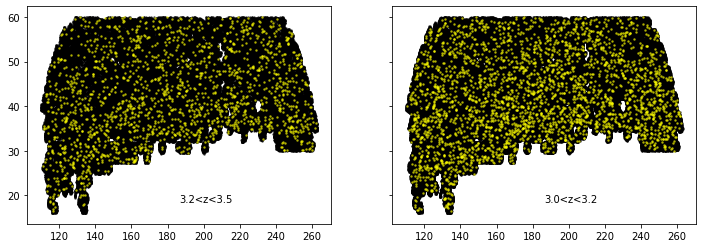

In [39]:
#---
gmask = (dNGC['Z'] > 3.2) & (dNGC['Z'] < 3.5)
rmask = (rNGC['Z'] > 3.2) & (rNGC['Z'] < 3.5)
#--- 
gmask1 = (dNGC['Z'] > 3.0) & (dNGC['Z'] < 3.2)
rmask1 = (rNGC['Z'] > 3.0) & (rNGC['Z'] < 3.2)


fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

labels = ['3.2<z<3.5', '3.0<z<3.2']
i = 0
for (g_i, r_i) in zip([gmask, gmask1], [rmask, rmask1]):
    
    # --- 
    ax[i].scatter(rNGC['RA'][r_i], rNGC['DEC'][r_i], 
                10, color='k', marker='.', alpha=0.5)
    ax[i].scatter(dNGC['RA'][g_i], dNGC['DEC'][g_i], 
                10, color='yellow', marker='.', alpha=0.5)
    ax[i].text(0.5, 0.1, labels[i], transform=ax[i].transAxes)
    i += 1

# Selection masks

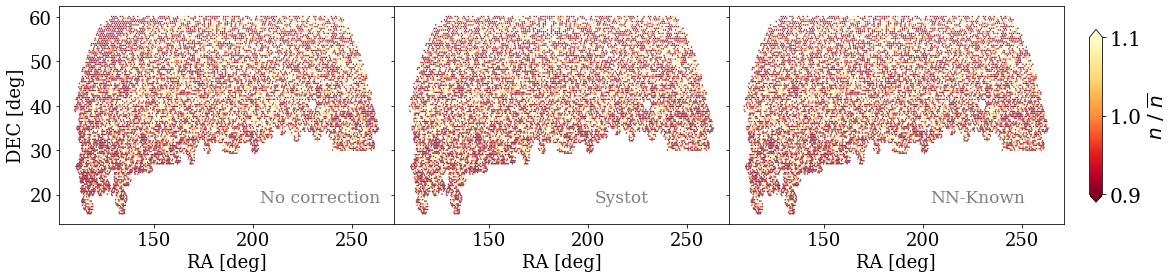

In [3]:
# ---- read data and random
data = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.dat.fits')
random = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3.ran.fits')

data_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.dat.fits')
random_nn = ft.read('/home/mehdi/data/eboss/v7_2/0.3/eBOSS_QSO_clustering_NGC_v7_2_0.3_known_allhigh.ran.fits')



#---- project to HEALPIX
nside  = 128
# hp.nside2resol(nside, arcmin=True)
# 27.483891294539248

hpmaps = {}

# data 
weight = data['WEIGHT_CP']*data['WEIGHT_FKP']*data['WEIGHT_NOZ']
hpmaps['ngal_none'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight)
hpmaps['ngal_systot'] = hpixsum(nside,  data['RA'], data['DEC'], value=weight*data['WEIGHT_SYSTOT'])

weightr = random['WEIGHT_CP']*random['WEIGHT_FKP']*random['WEIGHT_NOZ']*random['WEIGHT_SYSTOT']
hpmaps['nran_systot'] = hpixsum(nside,  random['RA'], random['DEC'], value=weightr)

weight_nn = data_nn['WEIGHT_CP']*data_nn['WEIGHT_FKP']*data_nn['WEIGHT_NOZ']
hpmaps['ngal_nn'] = hpixsum(nside,  data_nn['RA'], data_nn['DEC'], value=weight_nn*data_nn['WEIGHT_SYSTOT'])

weightr_nn = random_nn['WEIGHT_CP']*random_nn['WEIGHT_FKP']*random_nn['WEIGHT_NOZ']*random_nn['WEIGHT_SYSTOT']
hpmaps['nran_nn'] = hpixsum(nside,  random_nn['RA'], random_nn['DEC'], value=weightr_nn)


#---- using Randoms, compute the N/Nbar
# makedelta returns overdensity, we add 1 back to get N/Nbar
deltas = {}
deltas['none'] = overdensity(hpmaps['ngal_none'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['systot'] = overdensity(hpmaps['ngal_systot'], hpmaps['nran_systot'], hpmaps['nran_systot']>0) + 1
deltas['nn'] = overdensity(hpmaps['ngal_nn'], hpmaps['nran_nn'], hpmaps['nran_nn']>0) + 1

# np.array_equal(hpmaps['nran_nn']>0, hpmaps['nran_systot']>0)
# True
hpix = np.argwhere(hpmaps['nran_systot']>0).flatten()
ra, dec = hpix2radec(nside, hpix)

#--- set the font, figure size, etc
plt.rc('font', family='serif', size=18)

ncols = 3
fig, ax = plt.subplots(ncols=ncols, nrows=1, figsize=(6*ncols, 4), 
                       sharey='row', sharex='row')
fig.subplots_adjust(wspace=0.0)
ax= ax.flatten()

#--- plot 
kw = dict(vmax=1.1, vmin=0.9, cmap=plt.cm.YlOrRd_r, marker='.', rasterized=True)

ax[0].scatter(ra, dec, 1, c=deltas['none'][hpix], **kw)
ax[1].scatter(ra, dec, 1, c=deltas['systot'][hpix], **kw)
mapi = ax[2].scatter(ra, dec, 1, c=deltas['nn'][hpix], **kw)

#--- cosmetics
for i, (namei,axi) in enumerate(zip(['No correction', 'Systot', 'NN-Known'], ax)):    
    
    axi.set(xlabel='RA [deg]')    
    axi.text(0.6, 0.1, namei, color='grey',
             transform=axi.transAxes, fontsize=17)
    
    if i==0:
        axi.set(ylabel='DEC [deg]')

# colorbar
cax = plt.axes([0.92, 0.2, 0.01, 0.6])
cbar = fig.colorbar(mapi, cax=cax,
             shrink=0.7, ticks=[0.9, 1.0, 1.1], extend='both')
cbar.set_label(label=r'$n~/~\overline{n}$', size=20)
cbar.ax.tick_params(labelsize=20)

# savefig
fig.savefig('figs/qso_ngc_before_after_p3_v7_2.pdf', bbox_inches='tight', dpi=300)